In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

from sklearn.model_selection import train_test_split

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import hvplot.xarray

from mlprecip_utils import *

import warnings

/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib

In [2]:
warnings.filterwarnings("ignore")

### Set Variables for plotting, region, etc.

In [3]:
cmap='DryWet'
clevs=np.arange(-0.8,0.9,0.1)
labels=['Positive','Neutral','Negative']
v='precip'
lat_reg=[24.0,36.0]
lon_reg=[269.0,283.0]
winter=[12,1,2]
summer=[6,7,8]

### Read Precip Data
CPC 1/4 deg Monthly downloaded from:  https://psl.noaa.gov/data/gridded/data.unified.daily.conus.html

In [4]:
fname='/shared/obs/gridded/CPC-PRECIP-CONUS/monthly/precip.V1.0.mon.mean.nc'
ds=xr.open_dataset(fname)

### Subset to SE US

In [5]:
ds_seus=ds.sel(lat=slice(lat_reg[0],lat_reg[1]),lon=slice(lon_reg[0],lon_reg[1]))
ds_seus

<xarray.Dataset>
Dimensions:  (lat: 48, lon: 56, time: 846)
Coordinates:
  * lat      (lat) float32 24.12 24.38 24.62 24.88 ... 35.12 35.38 35.62 35.88
  * lon      (lon) float32 269.1 269.4 269.6 269.9 ... 282.1 282.4 282.6 282.9
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2018-06-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    history:        created 05/2012 by CAS from data obtained at NOAA NCEP/CPC
    description:    CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    References:     http://www.psl.noaa.gov/data/gridded/data.unified.daily.c...

### Calculate anoms in SEUS Region

In [6]:
ds_anoms=ds_seus.groupby('time.month')-ds_seus.groupby('time.month').mean()
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 48, lon: 56, time: 846)
Coordinates:
  * lat      (lat) float32 24.12 24.38 24.62 24.88 ... 35.12 35.38 35.62 35.88
  * lon      (lon) float32 269.1 269.4 269.6 269.9 ... 282.1 282.4 282.6 282.9
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2018-06-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 8 9 10 11 12 1 2 3 4 5 6
Data variables:
    precip   (time, lat, lon) float32 nan nan nan nan ... -0.3469 -0.437 -0.5924

### Make index by averaging over region

In [7]:
ds_anoms_index=ds_anoms.mean(dim=['lat','lon'])
ds_anoms_index

<xarray.Dataset>
Dimensions:  (time: 846)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2018-06-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 8 9 10 11 12 1 2 3 4 5 6
Data variables:
    precip   (time) float32 0.1632 0.4818 2.649 -0.1696 ... 0.759 1.534 -0.101

### Plot Index by Season

In [8]:
ds_anoms_index.hvplot.step(by='time.season',x='time.year',subplots=True).cols(2)

:NdLayout   [time.season]
   :Curve   [time.year]   (precip)

### Plot Seasonal Mean and Standard Deviation

In [9]:
ds_seus['precip'].mean(dim=['lat','lon']).groupby('time.season').mean().hvplot.bar(title='Seasonal Mean SEUS Precip')+\
ds_anoms_index['precip'].groupby('time.season').std().hvplot.bar(title='Seasonal Std SEUS Precip',shared_axes=False)

:Layout
   .Bars.I  :Bars   [season,Variable]   (value)
   .Bars.II :Bars   [season,Variable]   (value)

### Read Monthly Climate Indices from ESRL/PSL 
AMO, NAO, NINO34, PDO

In [10]:
indices=['amo','nao','nino34','pdo']

ds_indices_list=[]
for i in indices:
    
    df=pd.read_table('/data/ccsm4/kpegion/obs2/CLIM_INDICES/'+i+'.txt',skiprows=1,
                     header=None,delim_whitespace=True,
                     index_col=0,parse_dates=True,
                     na_values=['-99.9','-99.90','-99.99']).dropna()
    
    start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
    end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'
    dates=pd.date_range(start=start_date,end=end_date,freq='MS')
    clim_index=df.T.unstack().values
    ds_index=xr.DataArray(clim_index.astype('float'),coords={'time':dates},dims=['time'])      
    
    ds_indices_list.append(ds_index.to_dataset(name=i))

ds_indices_list.append(ds_anoms_index)

ds_indices=xr.merge(ds_indices_list).dropna(dim='time')
ds_indices

<xarray.Dataset>
Dimensions:  (time: 822)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2018-06-01
    month    (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 1.0 2.0 3.0 4.0 5.0 6.0
Data variables:
    amo      (time) float64 0.108 -0.036 -0.108 -0.133 ... 0.051 -0.013 -0.024
    nao      (time) float64 0.56 0.01 -0.78 0.65 -0.5 ... -1.38 1.2 2.02 1.41
    nino34   (time) float64 -1.99 -1.69 -1.42 -1.54 ... -0.8 -0.51 -0.2 0.04
    pdo      (time) float64 -2.13 -2.91 -1.13 -1.2 ... -0.05 0.11 0.11 -0.04
    precip   (time) float32 -0.09544 -0.8248 0.5145 ... 0.759 1.534 -0.101

### Detrend and Standardize Indices

In [11]:
for v in list(ds_indices.keys()):

    detrend=signal.detrend(ds_indices[v],axis=0,type='linear')     
    ds_indices[v]=xr.DataArray(detrend,coords={'time': ds_indices['time'].values},dims=['time'])     
    
ds_indices=(ds_indices-ds_indices.mean(dim='time'))/ds_indices.std(dim='time')

### Quick Look Plots of Indices

In [12]:
ds_indices.hvplot.line(x='time',subplots=True,shared_axes=False).cols(2)

:NdLayout   [Variable]
   :Curve   [time]   (value)

### Main Program

Winter
AMO
Positive 99
Neutral 32
Negative 75
NAO
Positive 90
Neutral 45
Negative 71
NINO34
Positive 100
Neutral 28
Negative 78
PDO
Positive 87
Neutral 50
Negative 69
Check Features and Target Dimensions
Features (X):  (206, 4)
Target (Y):  (206,)
Samples:  206
Features:  4
Training Size:  164
Testing Size:  42
Check Stats:  Index:  amo Mean:  -0.21280765461520956 Var:  0.9251996693227004
Check Stats:  Index:  nao Mean:  -0.21324199850399364 Var:  0.9349843499872198
Check Stats:  Index:  nino34 Mean:  0.11912982408057635 Var:  1.4388665790002948
Check Stats:  Index:  pdo Mean:  -0.03415686313328224 Var:  0.9503462471656946
R^2 Train Standard :  0.3140695217558827
R^2 Train LASSO :  0.29265106925460244
R^2 Train Ridge :  0.3139316503092708
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
R^2 Train NN:  0.3955395004519021
R^2 Test Standard:  0.36155214523059787
R^2 Test Lasso:  0.3764089036471602
R^2 Test Ridge:  0.3615

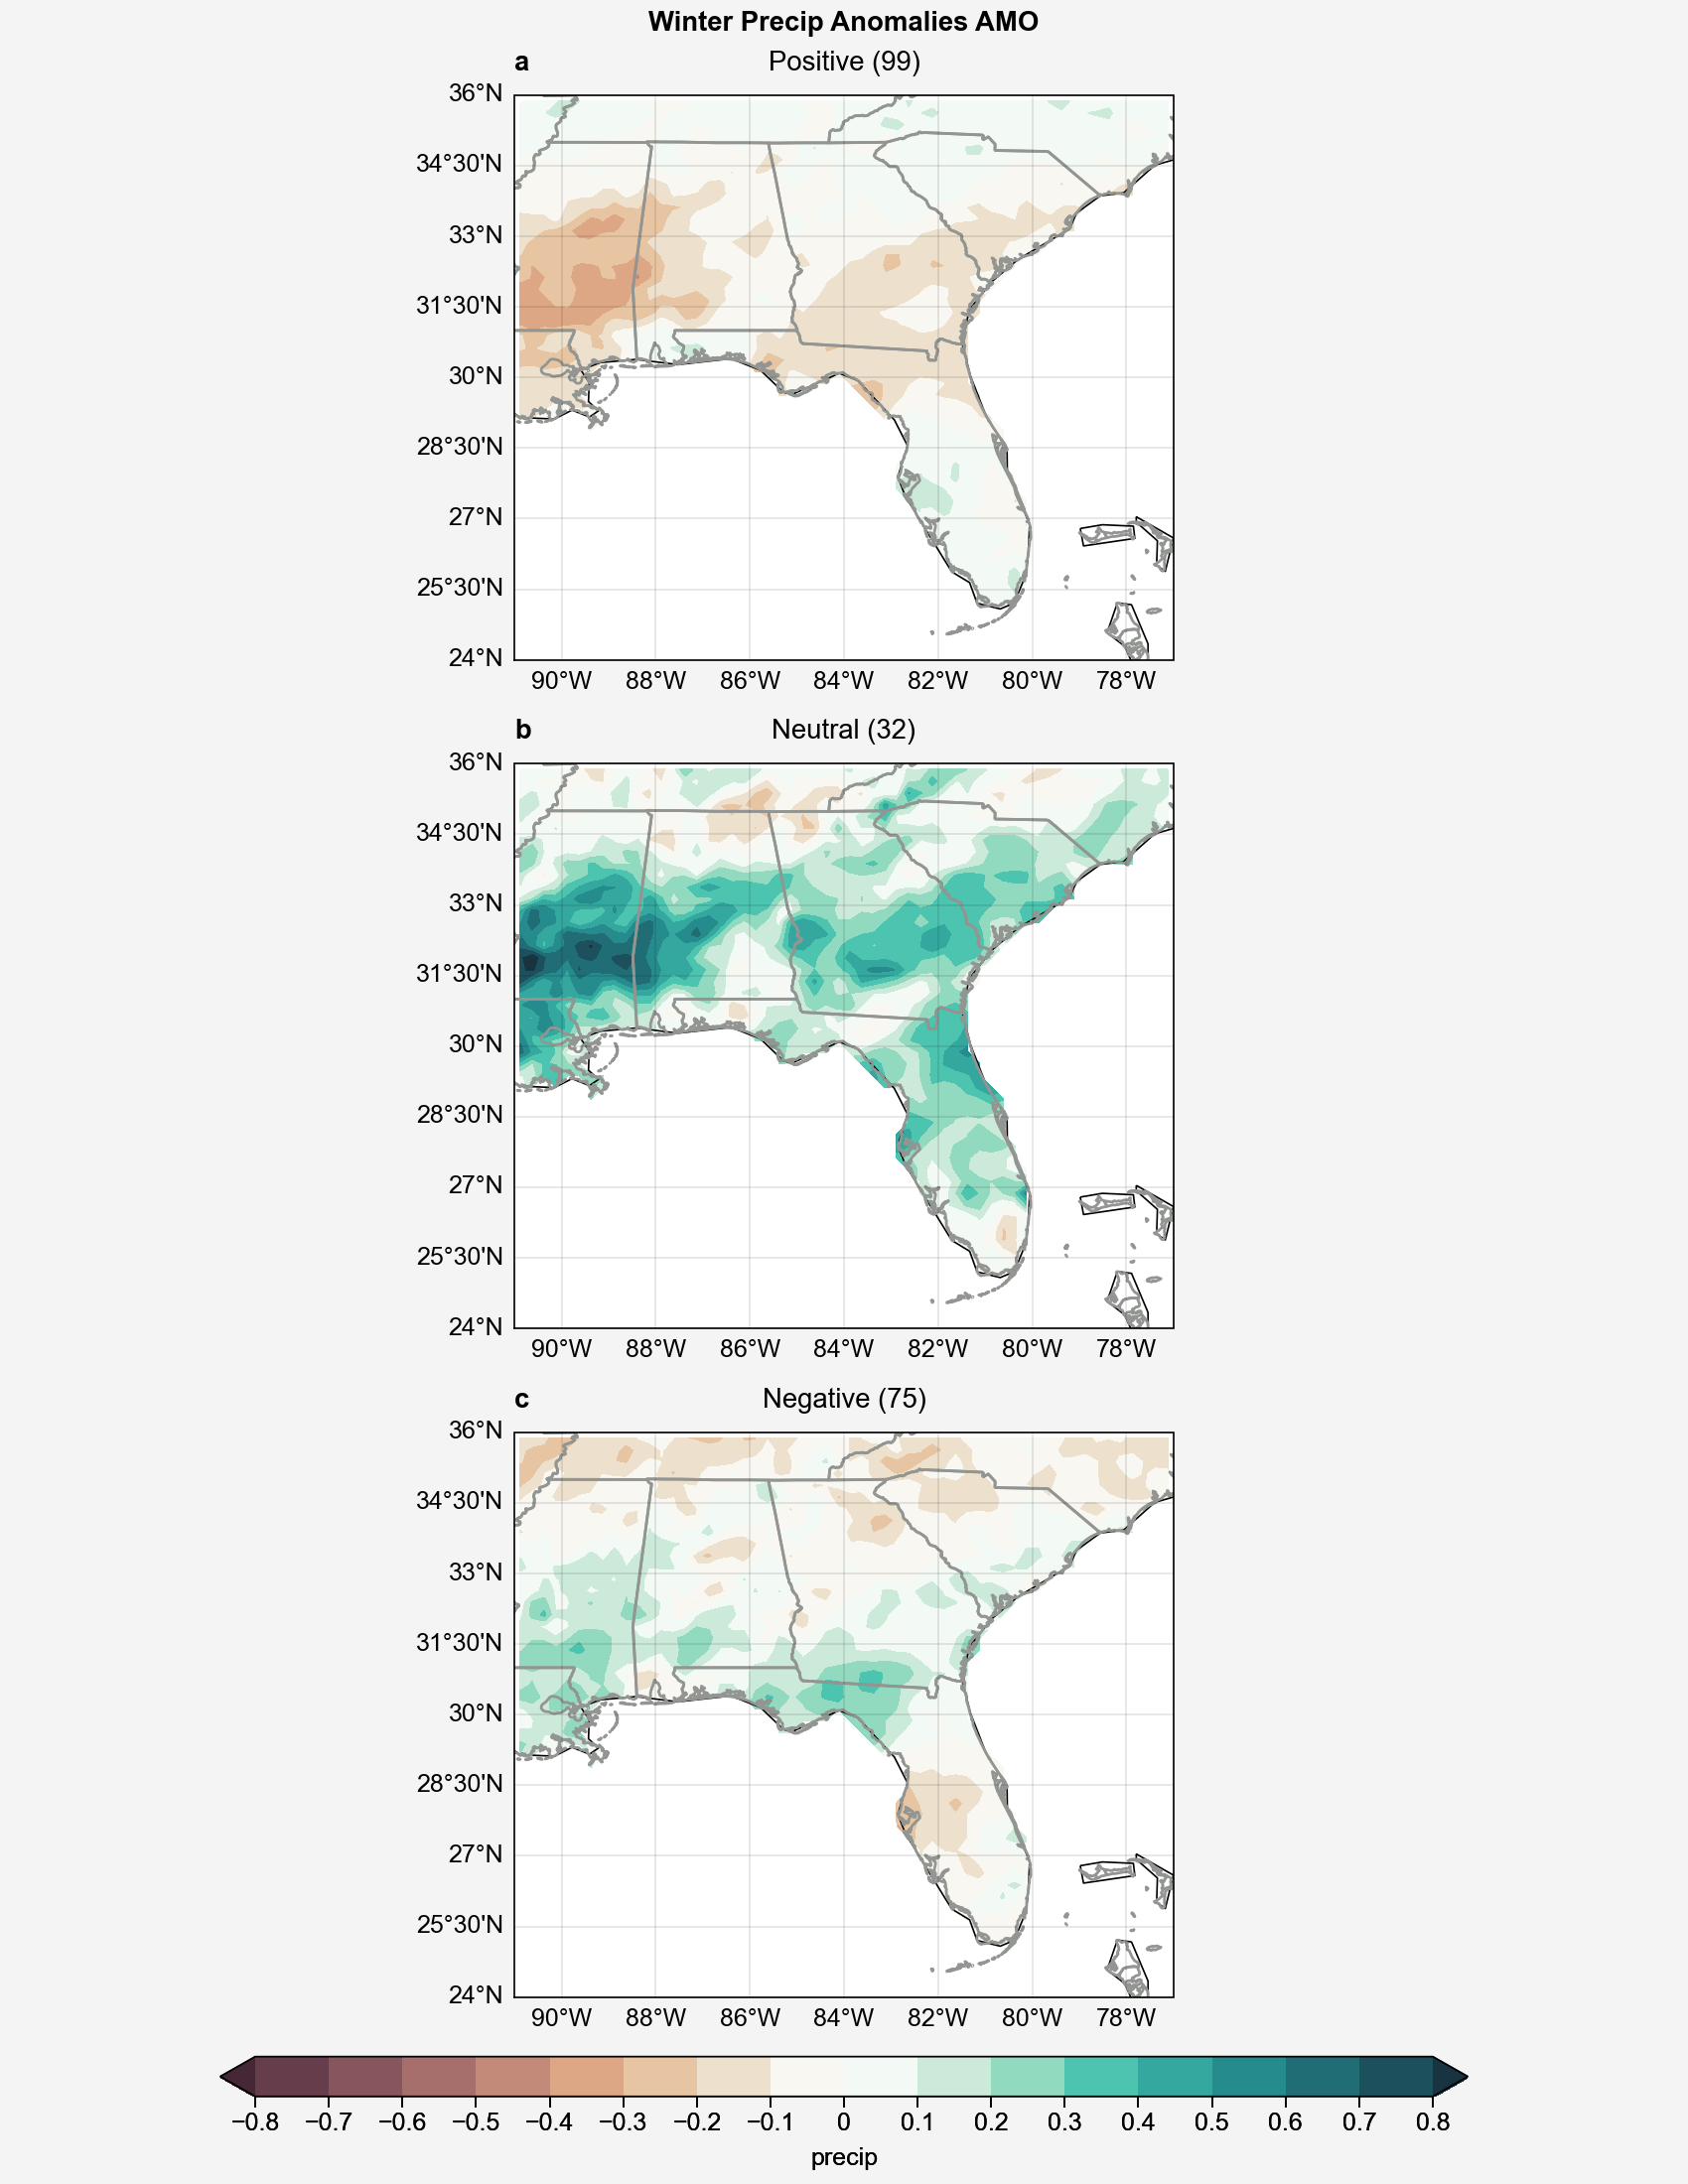

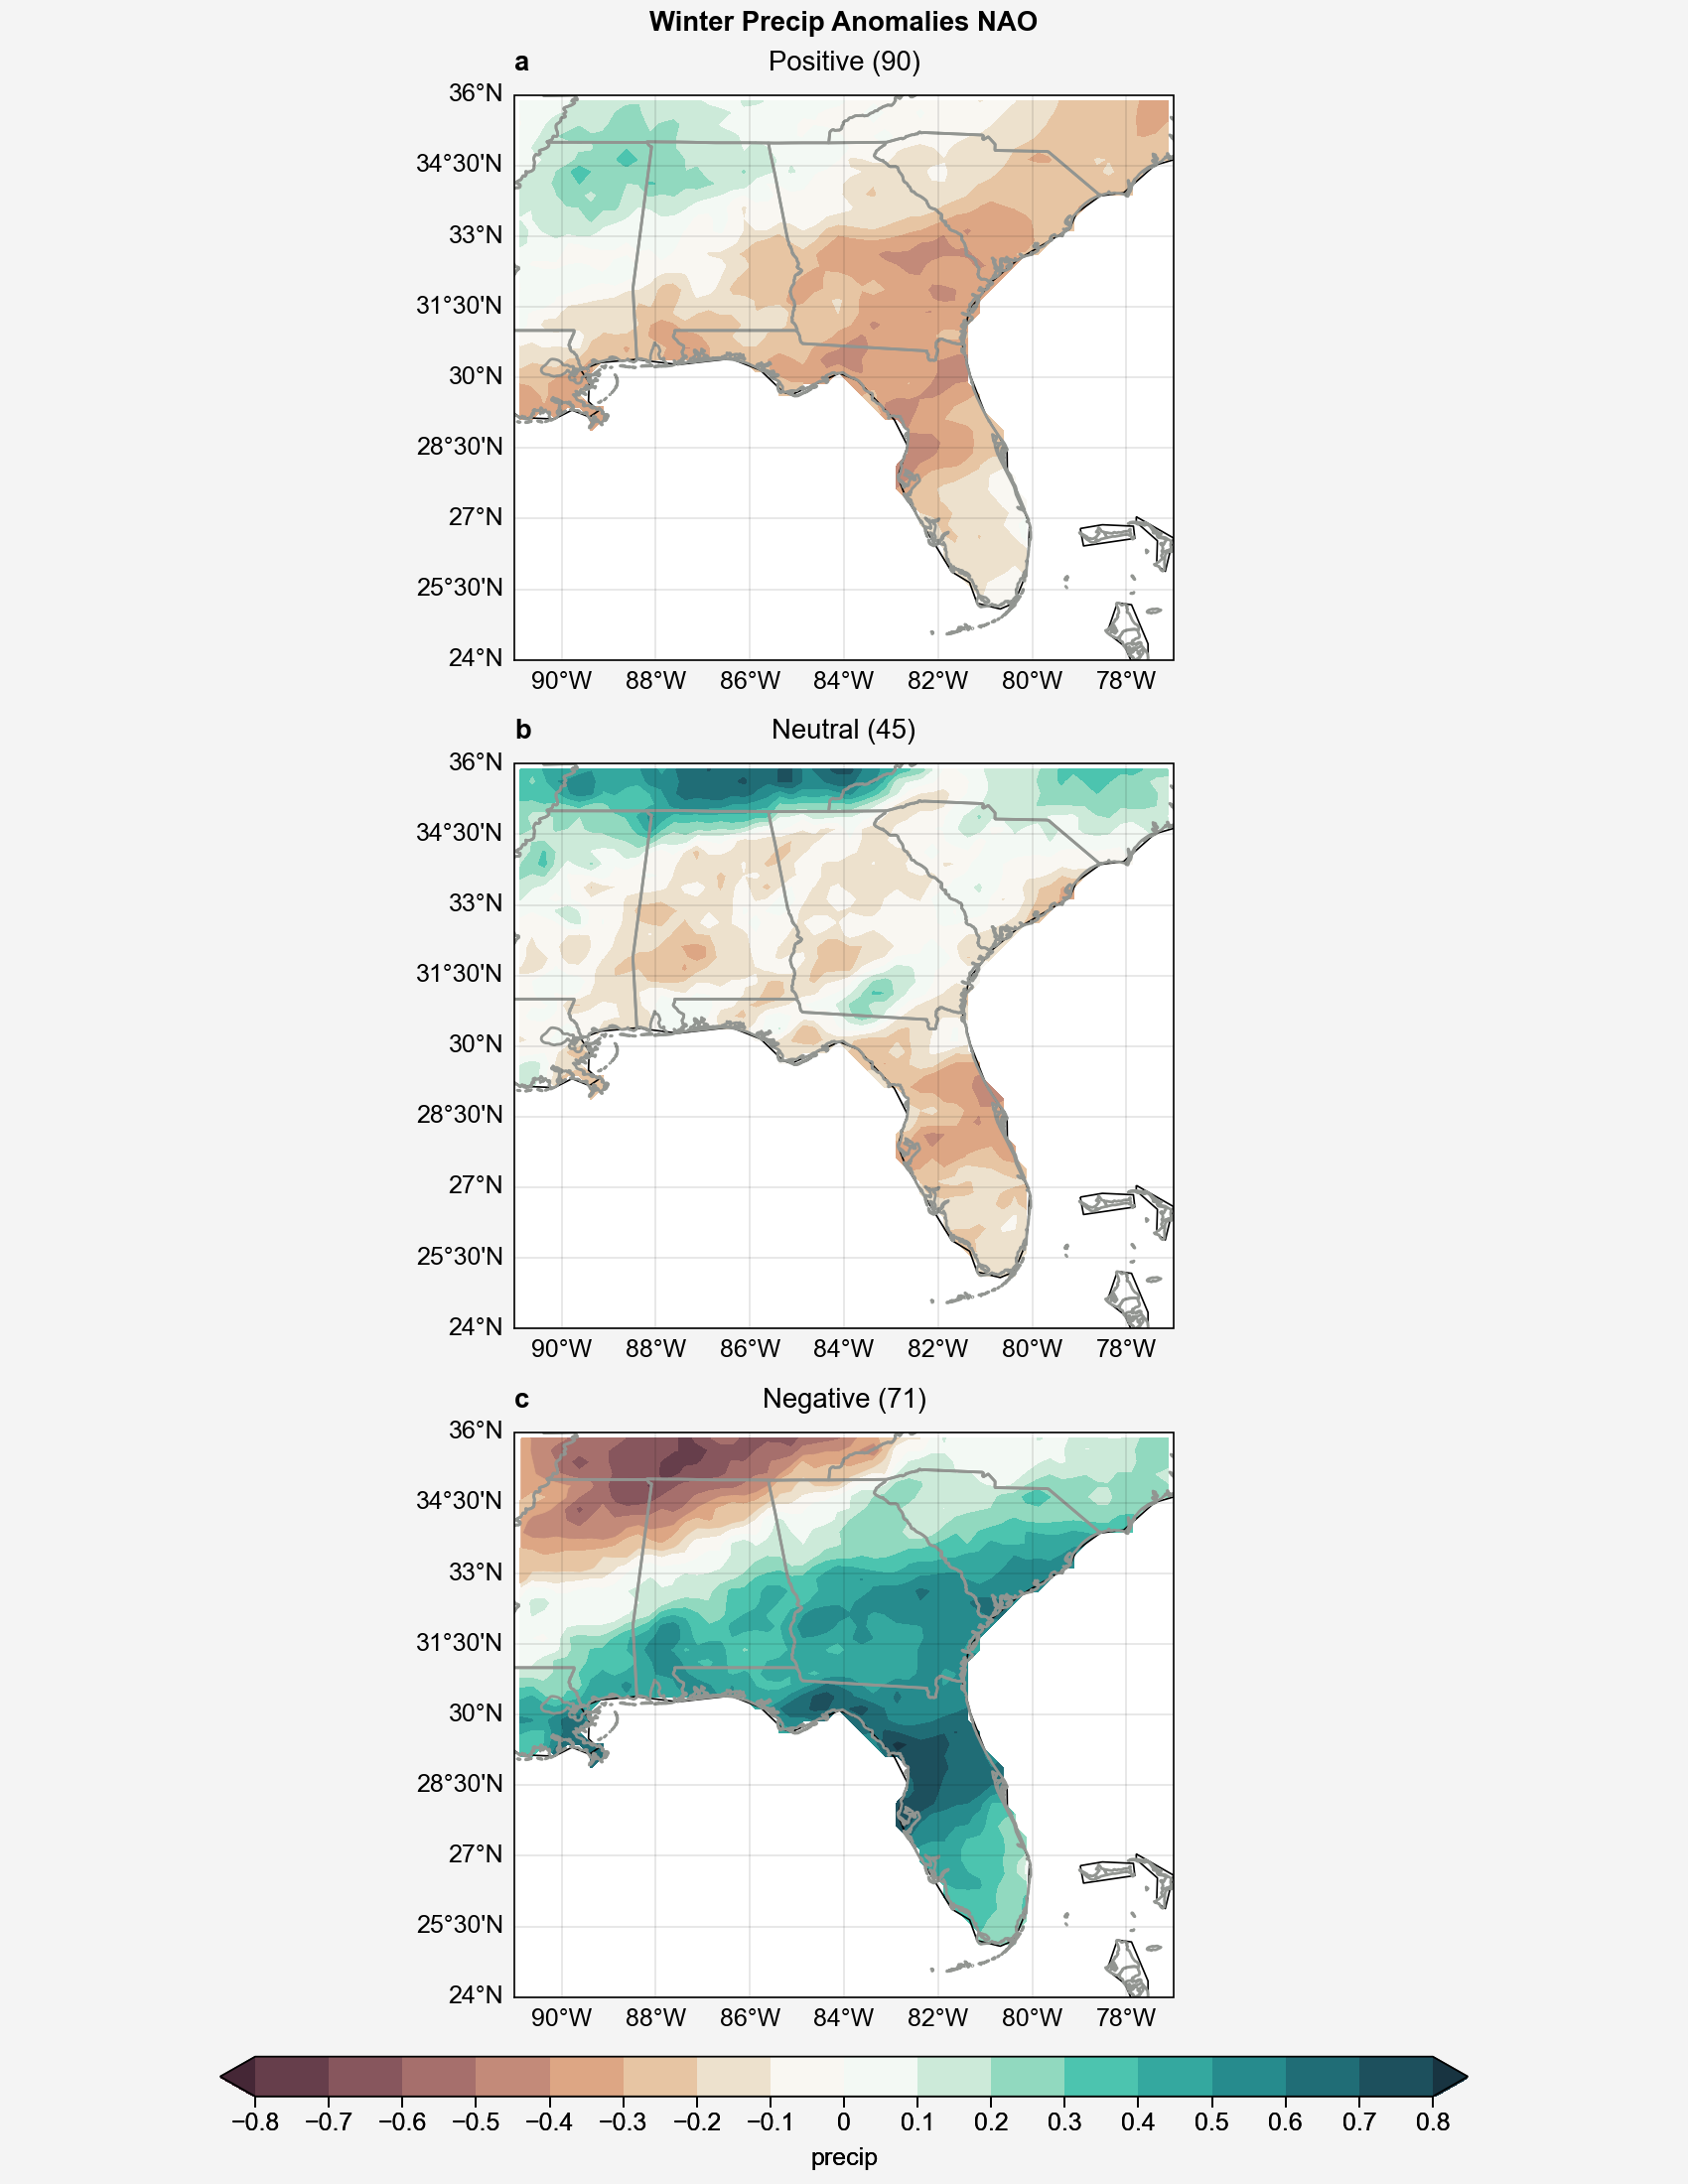

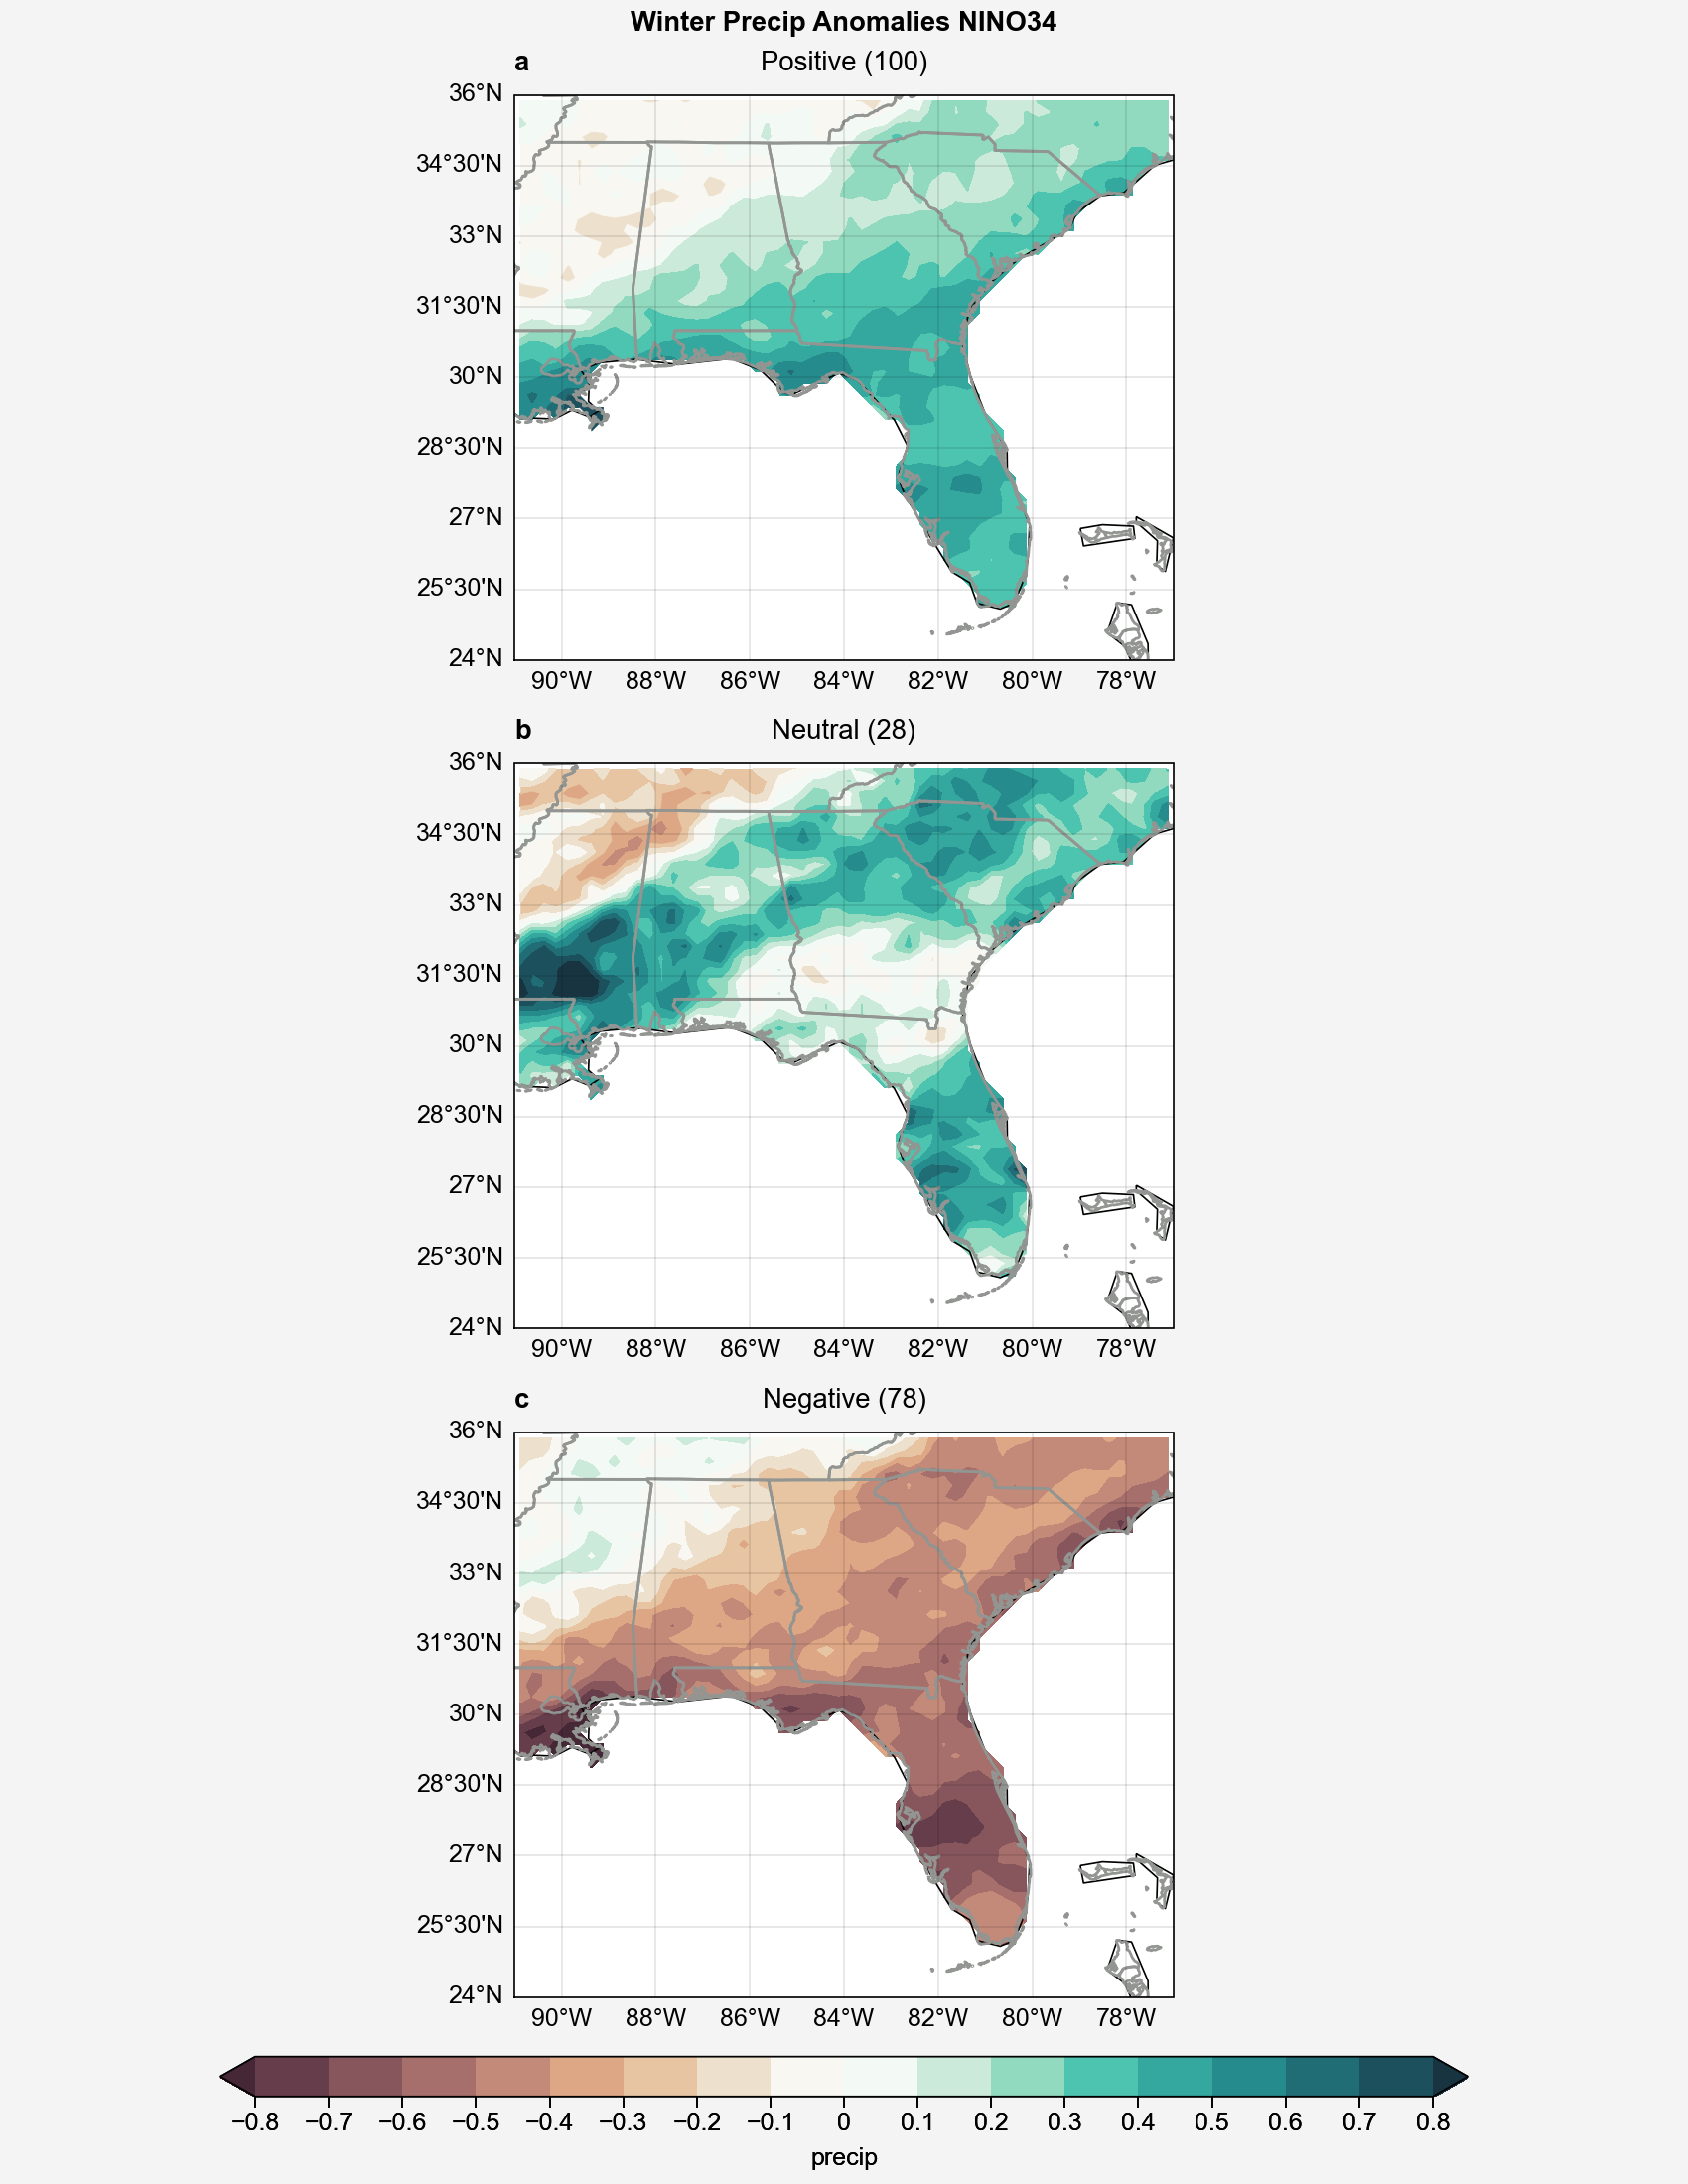

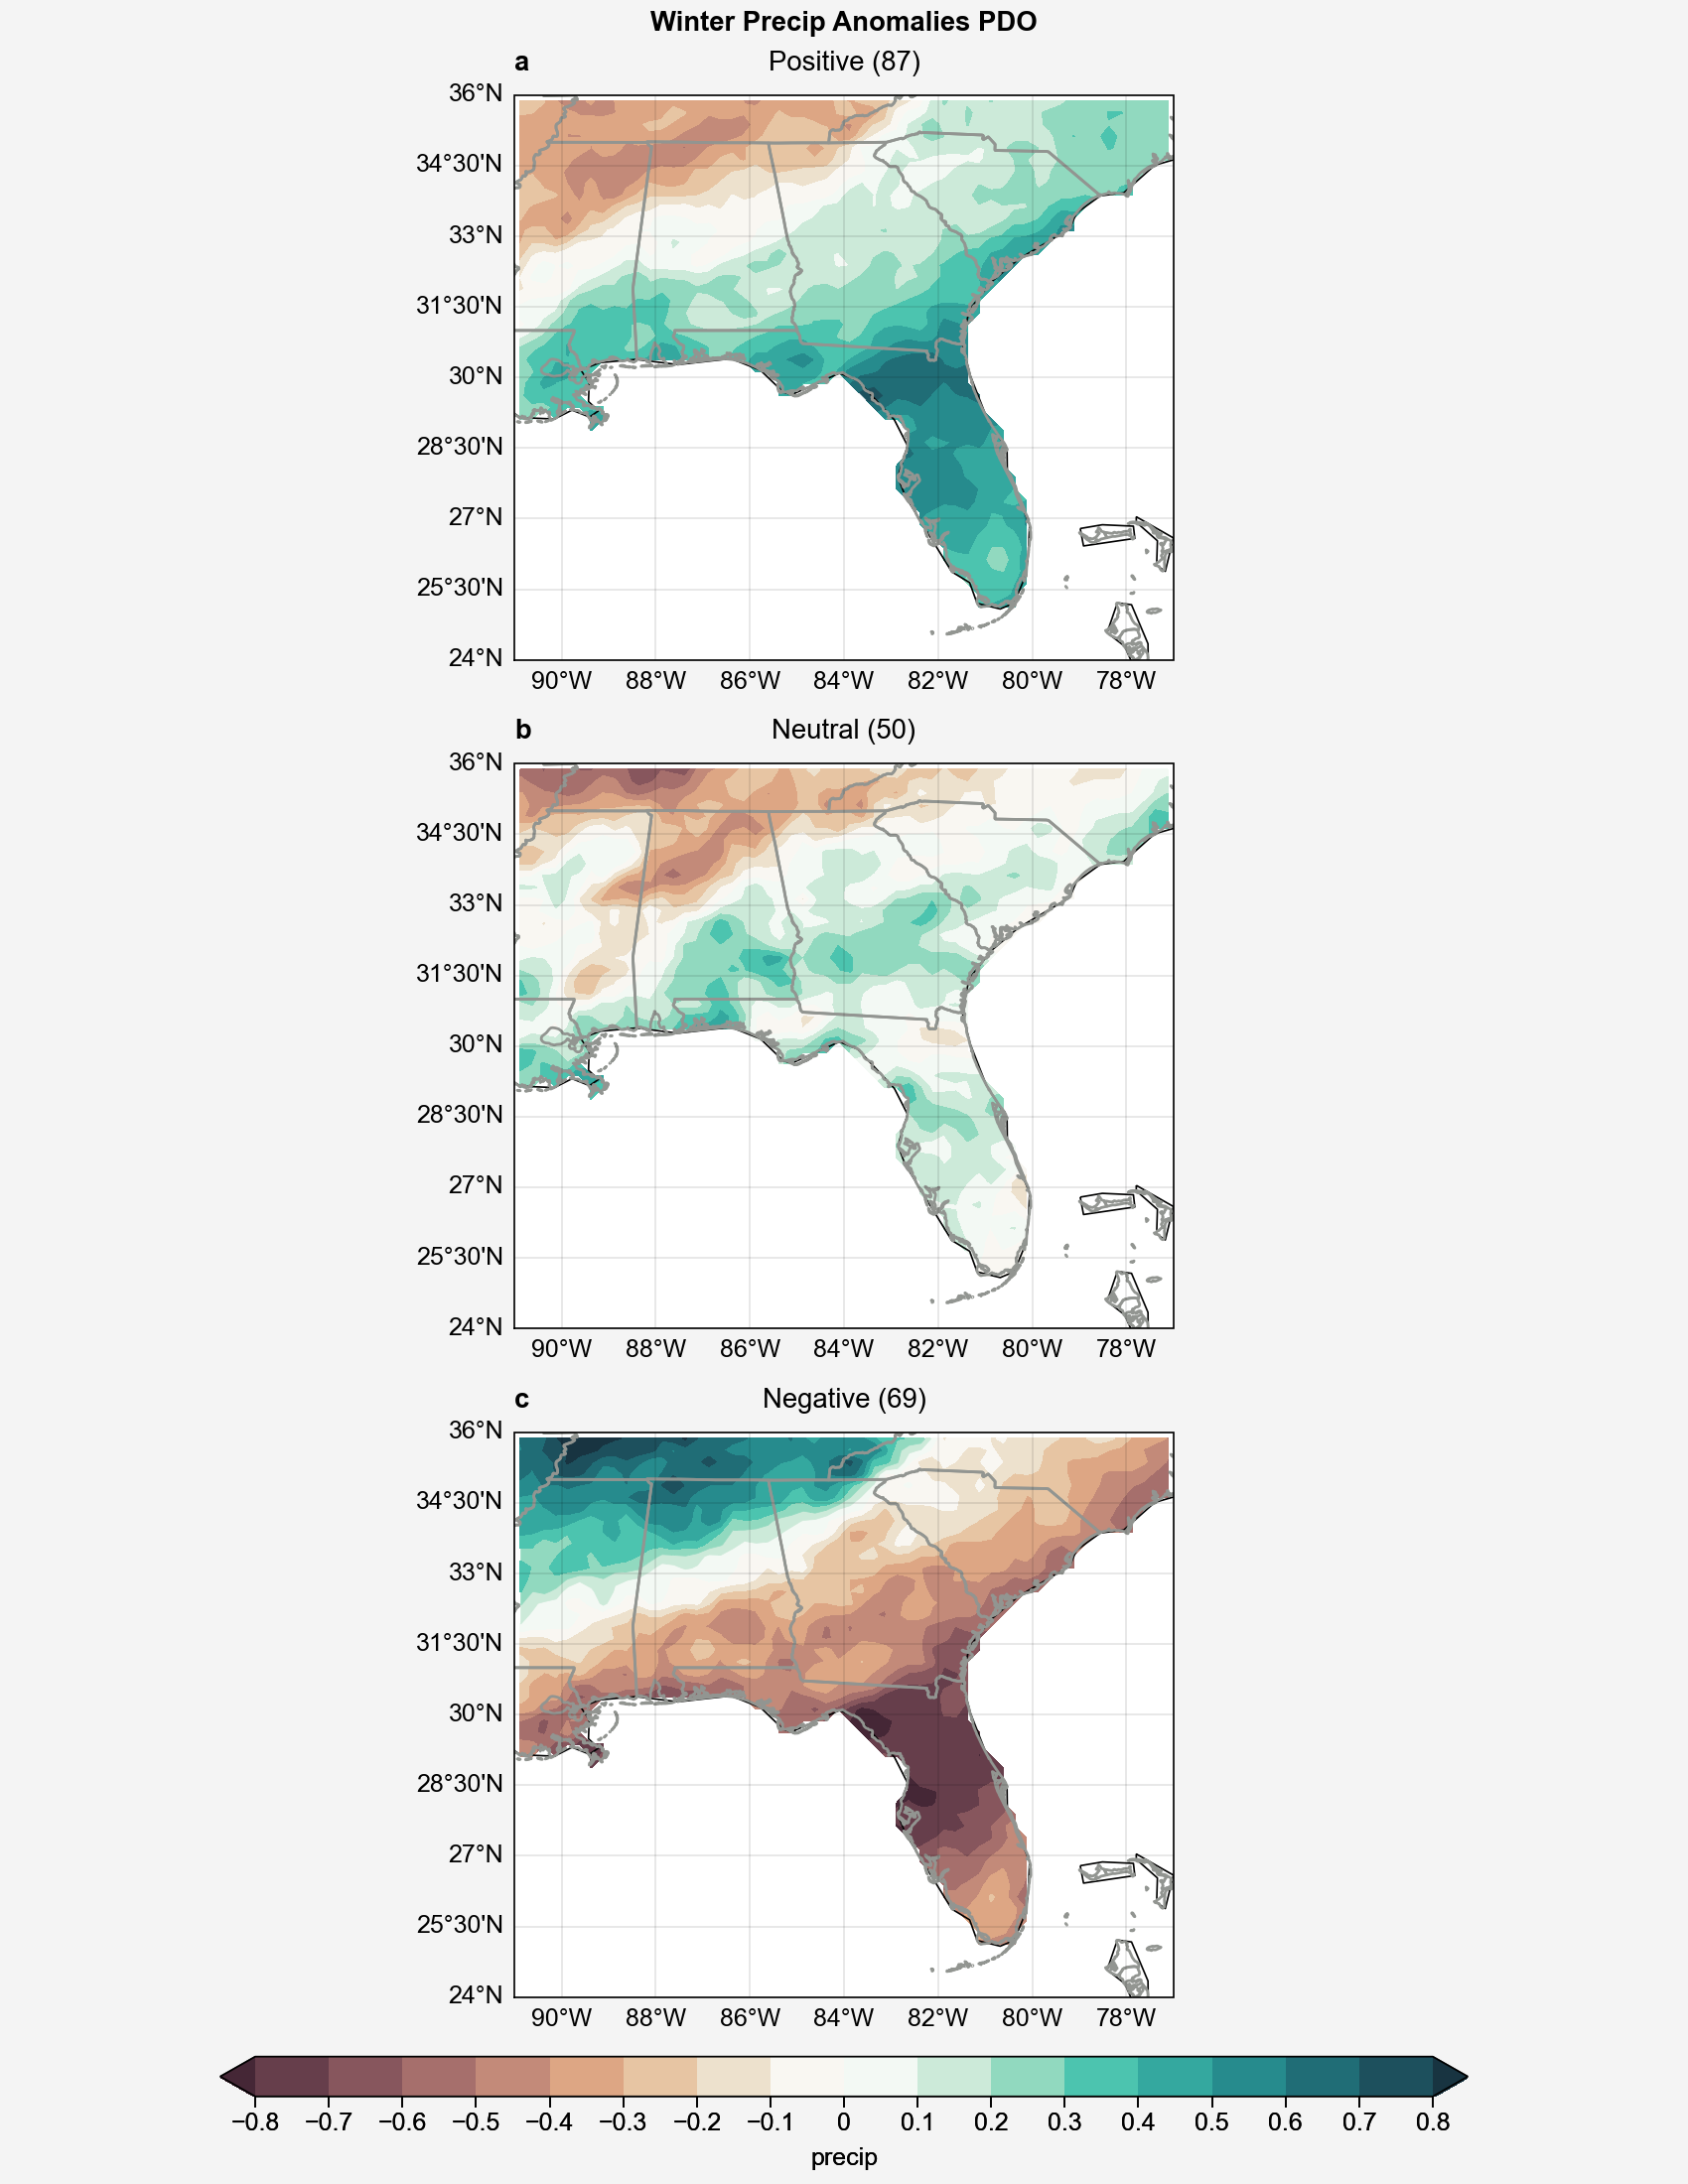

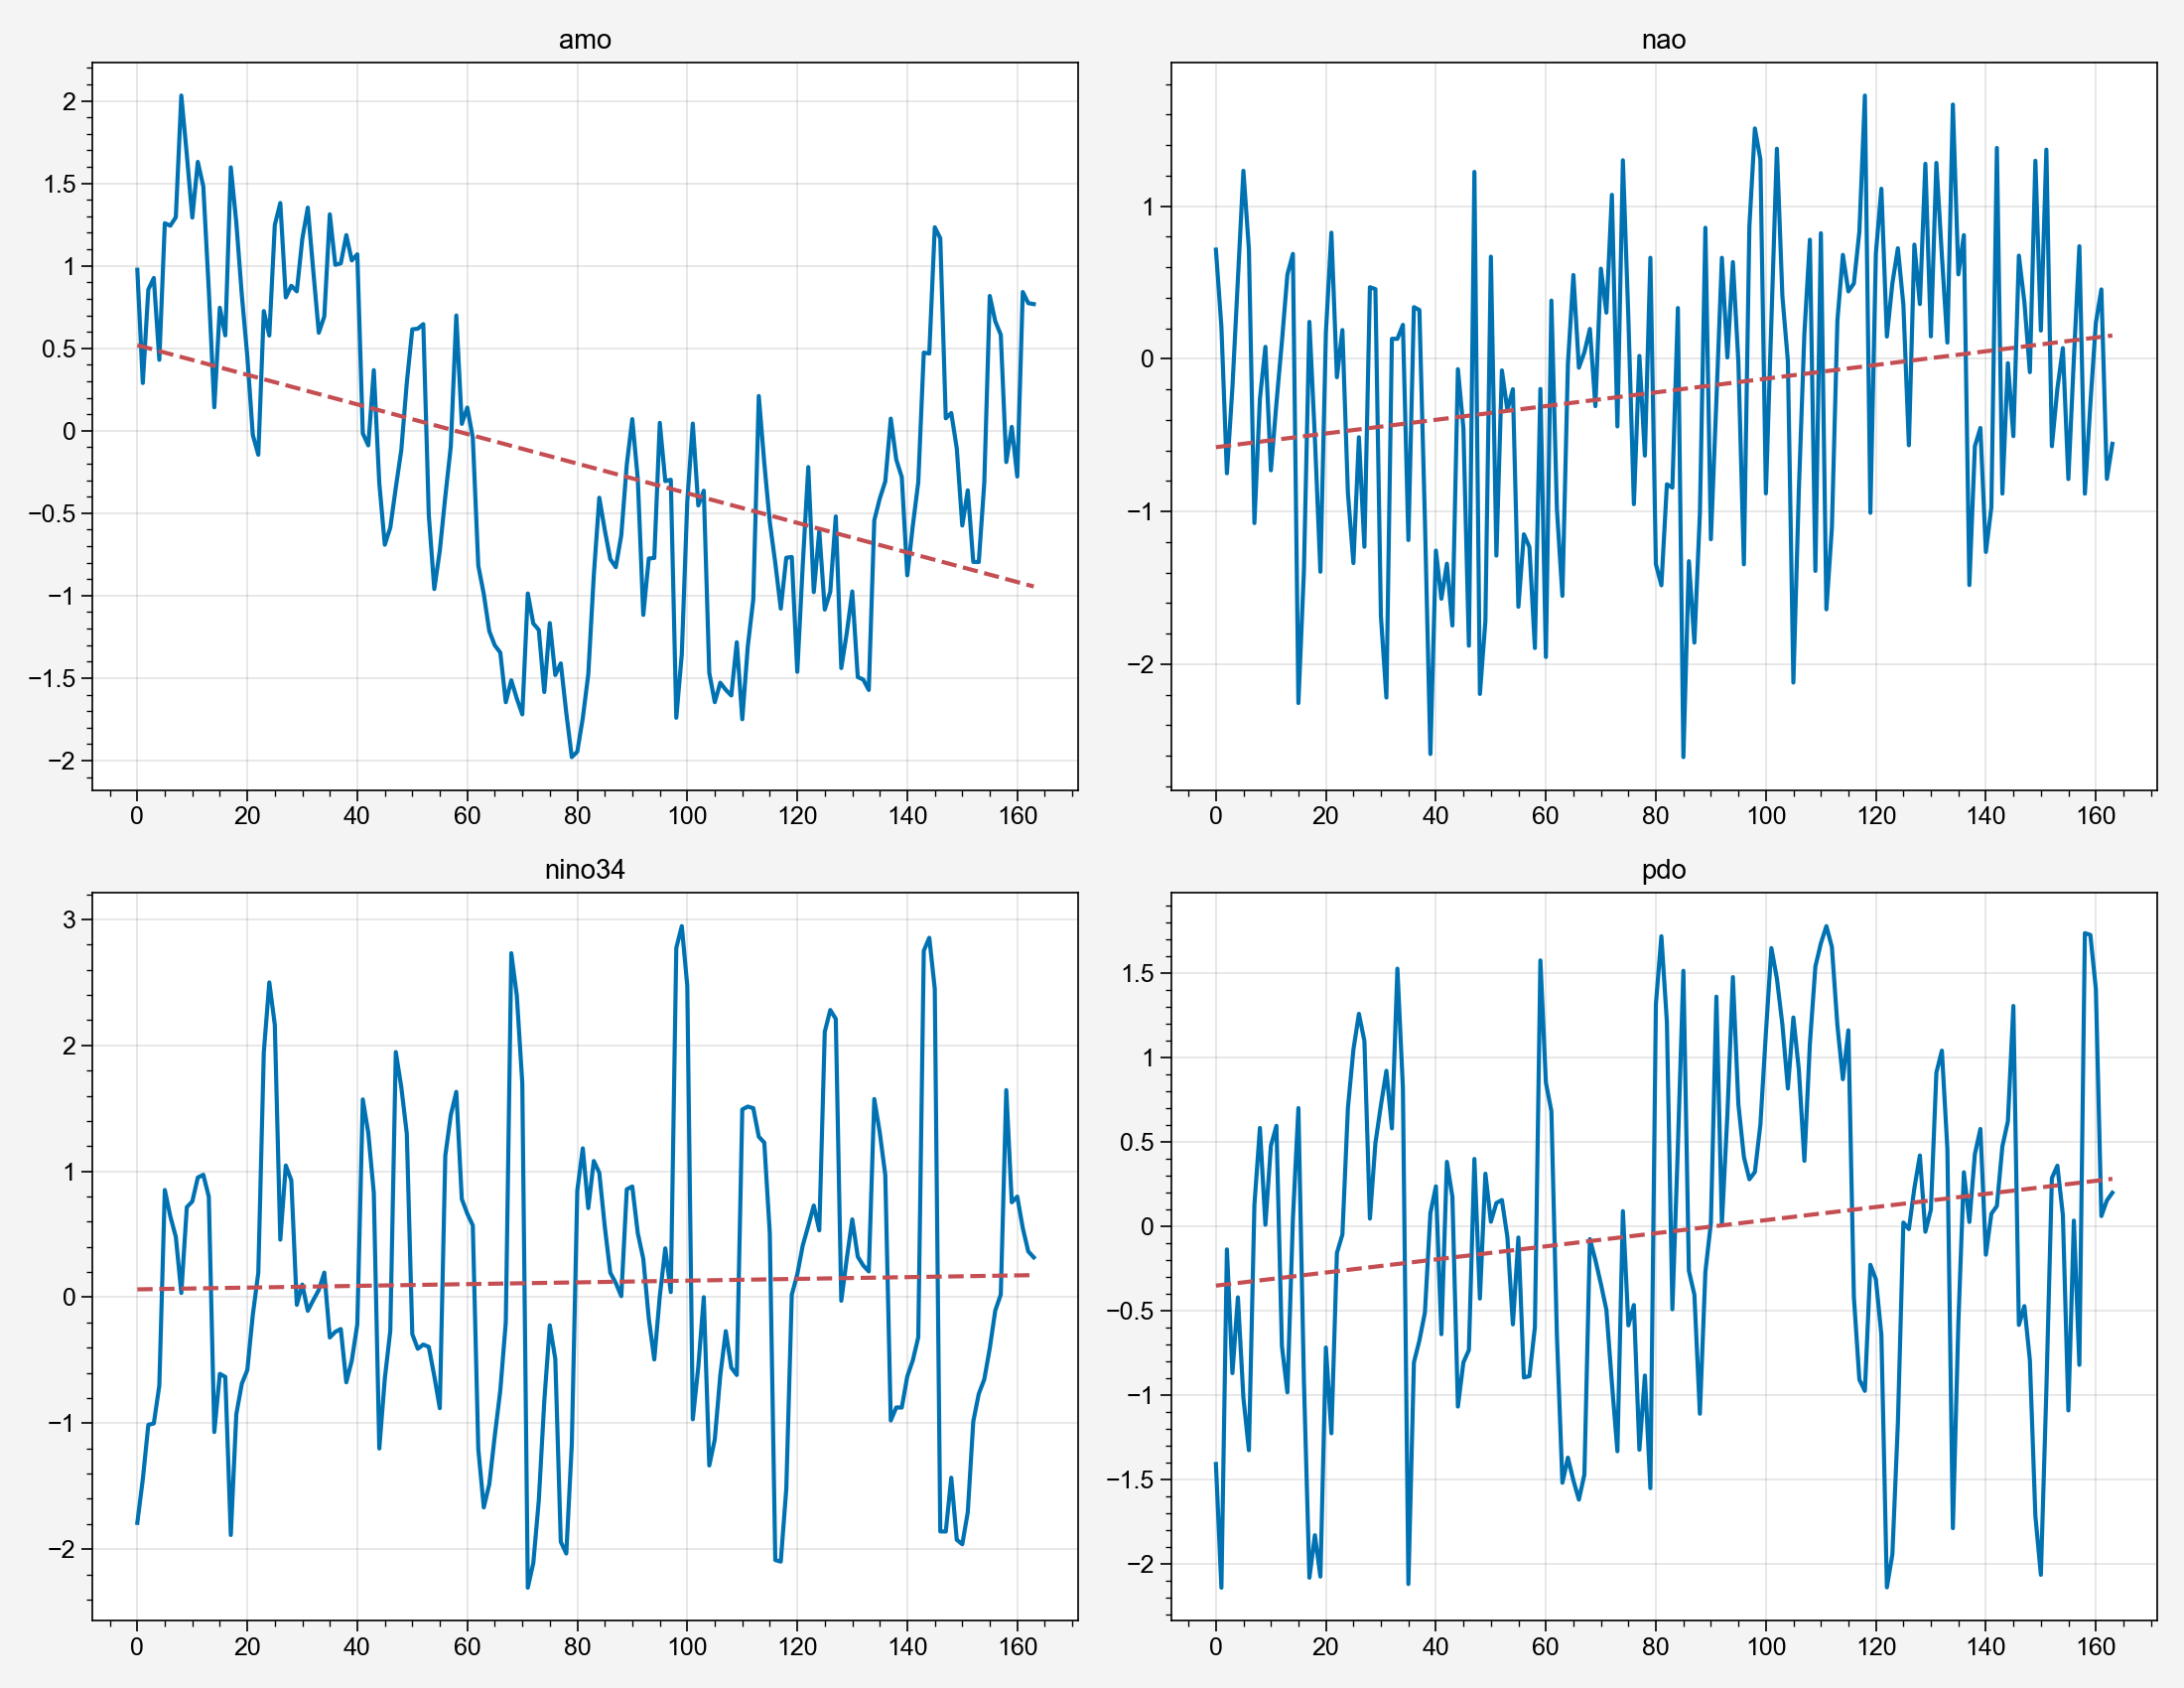

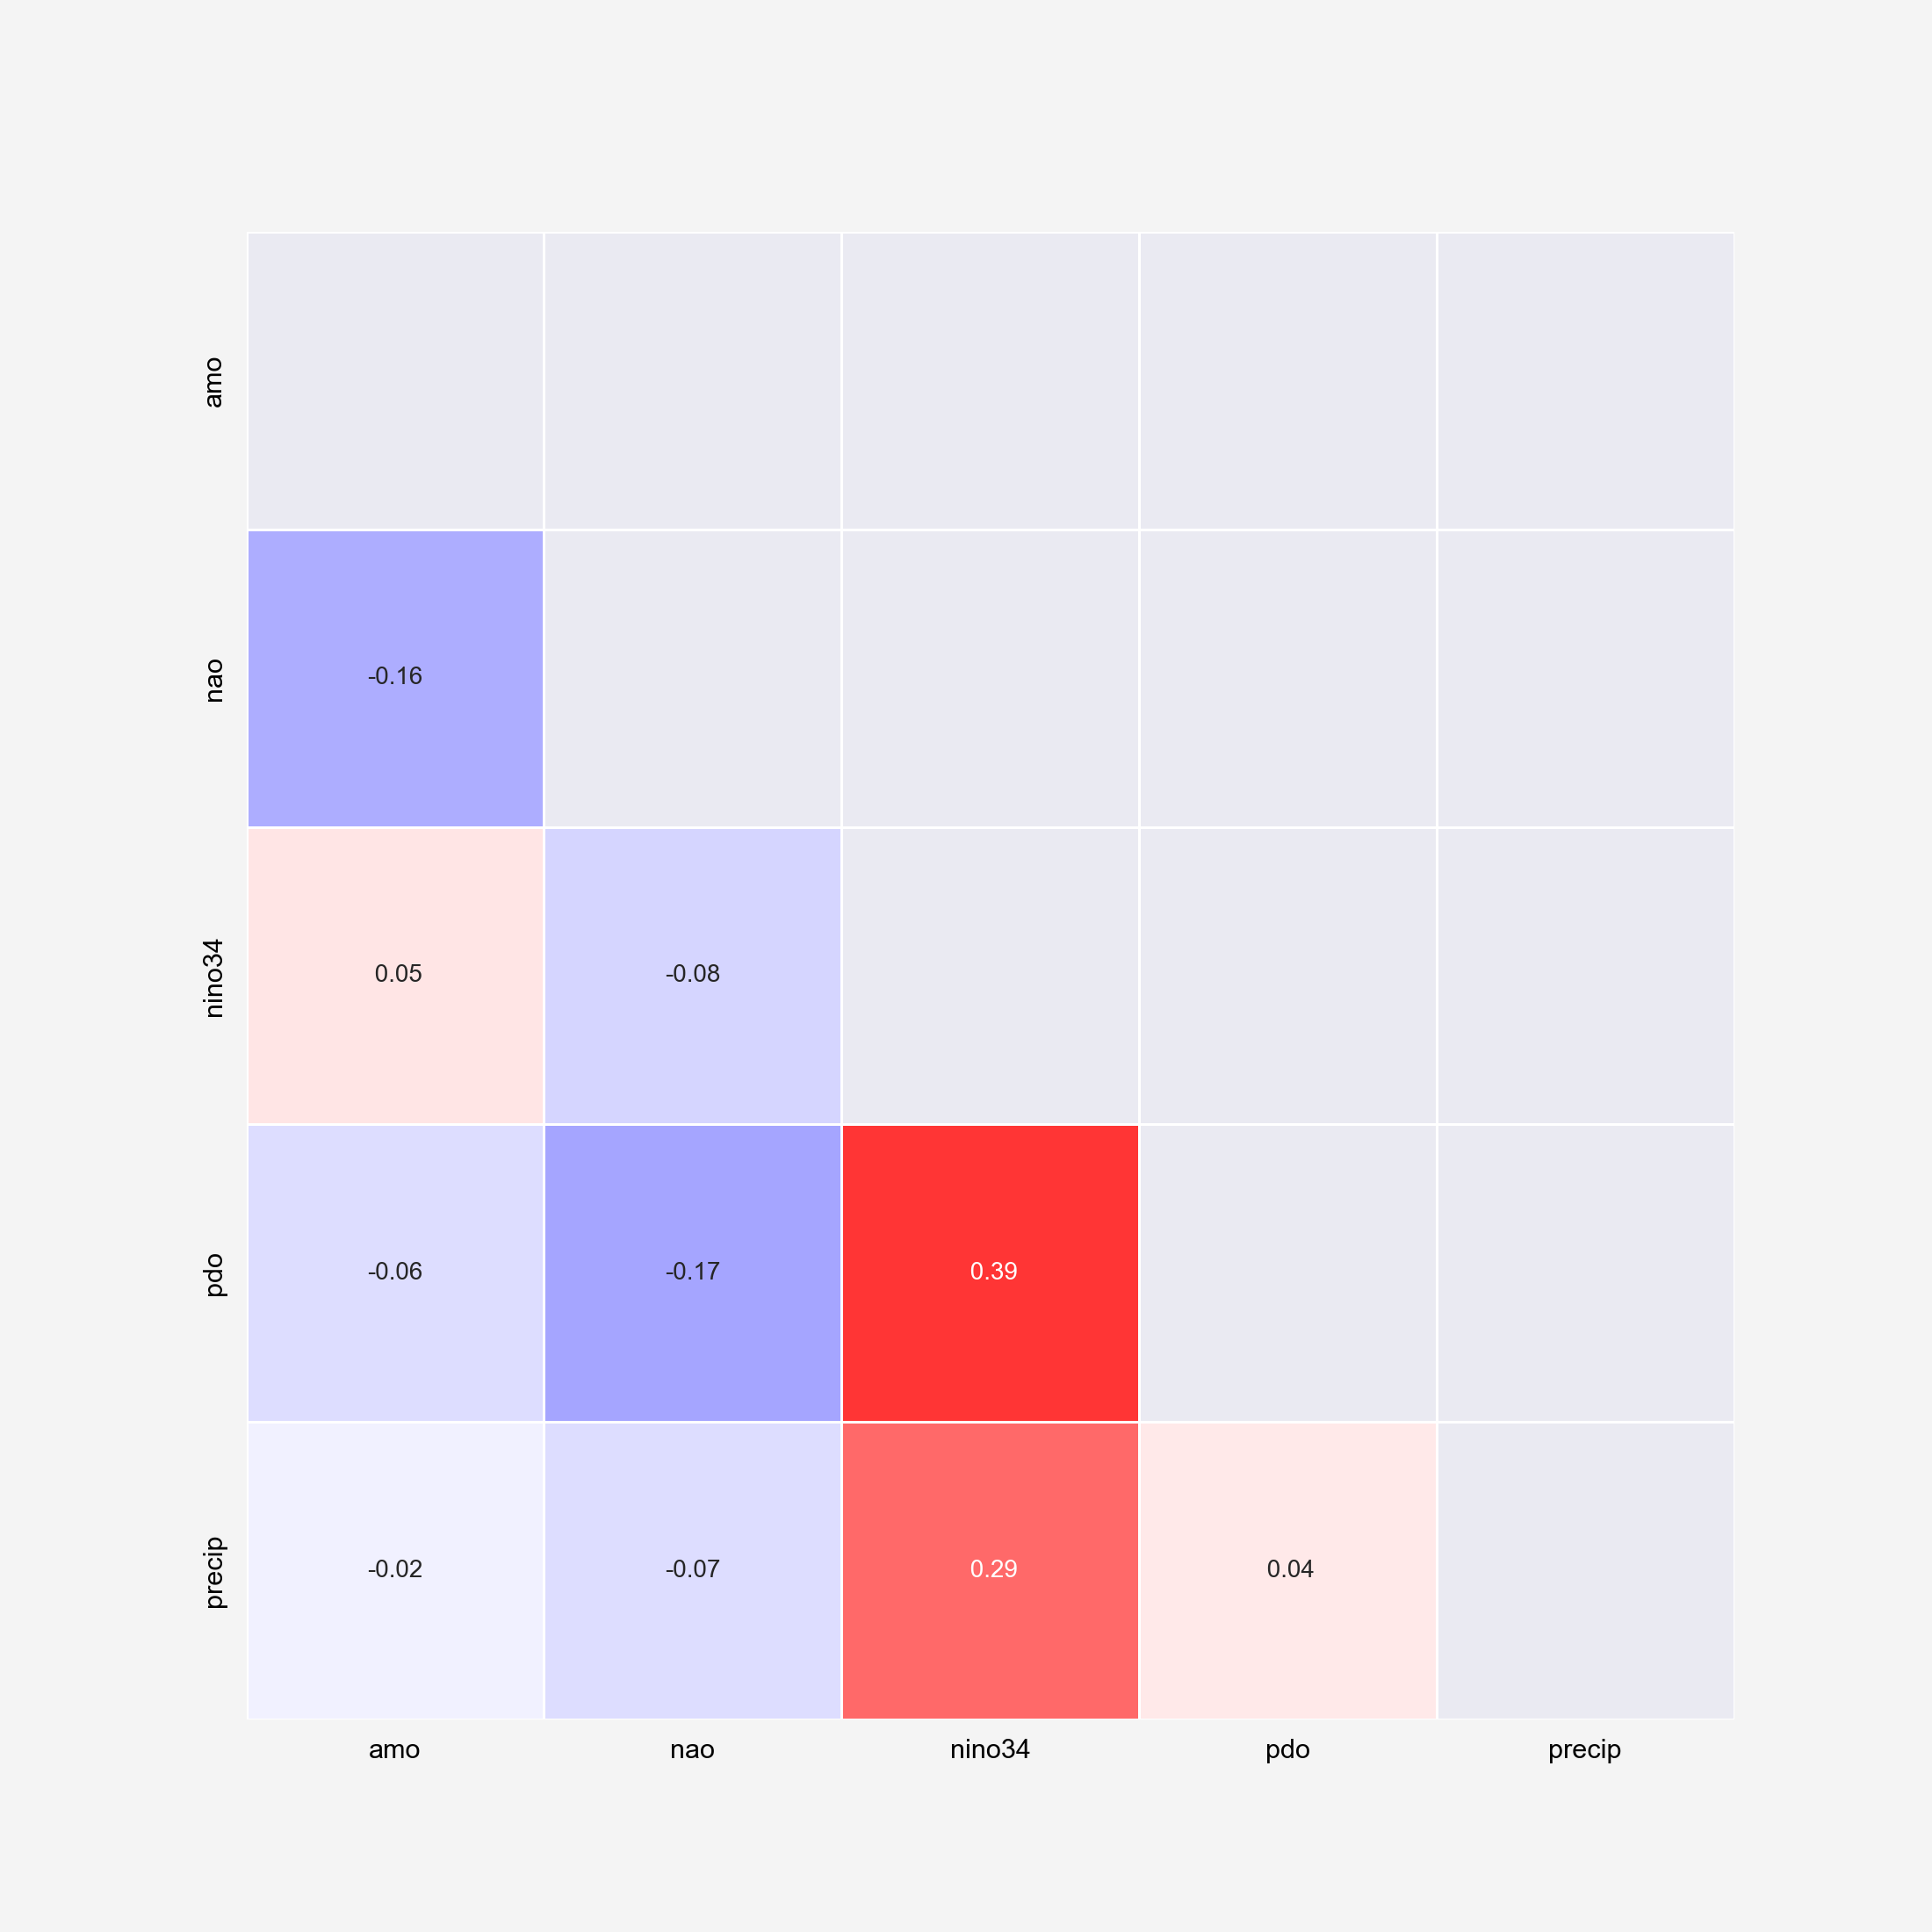

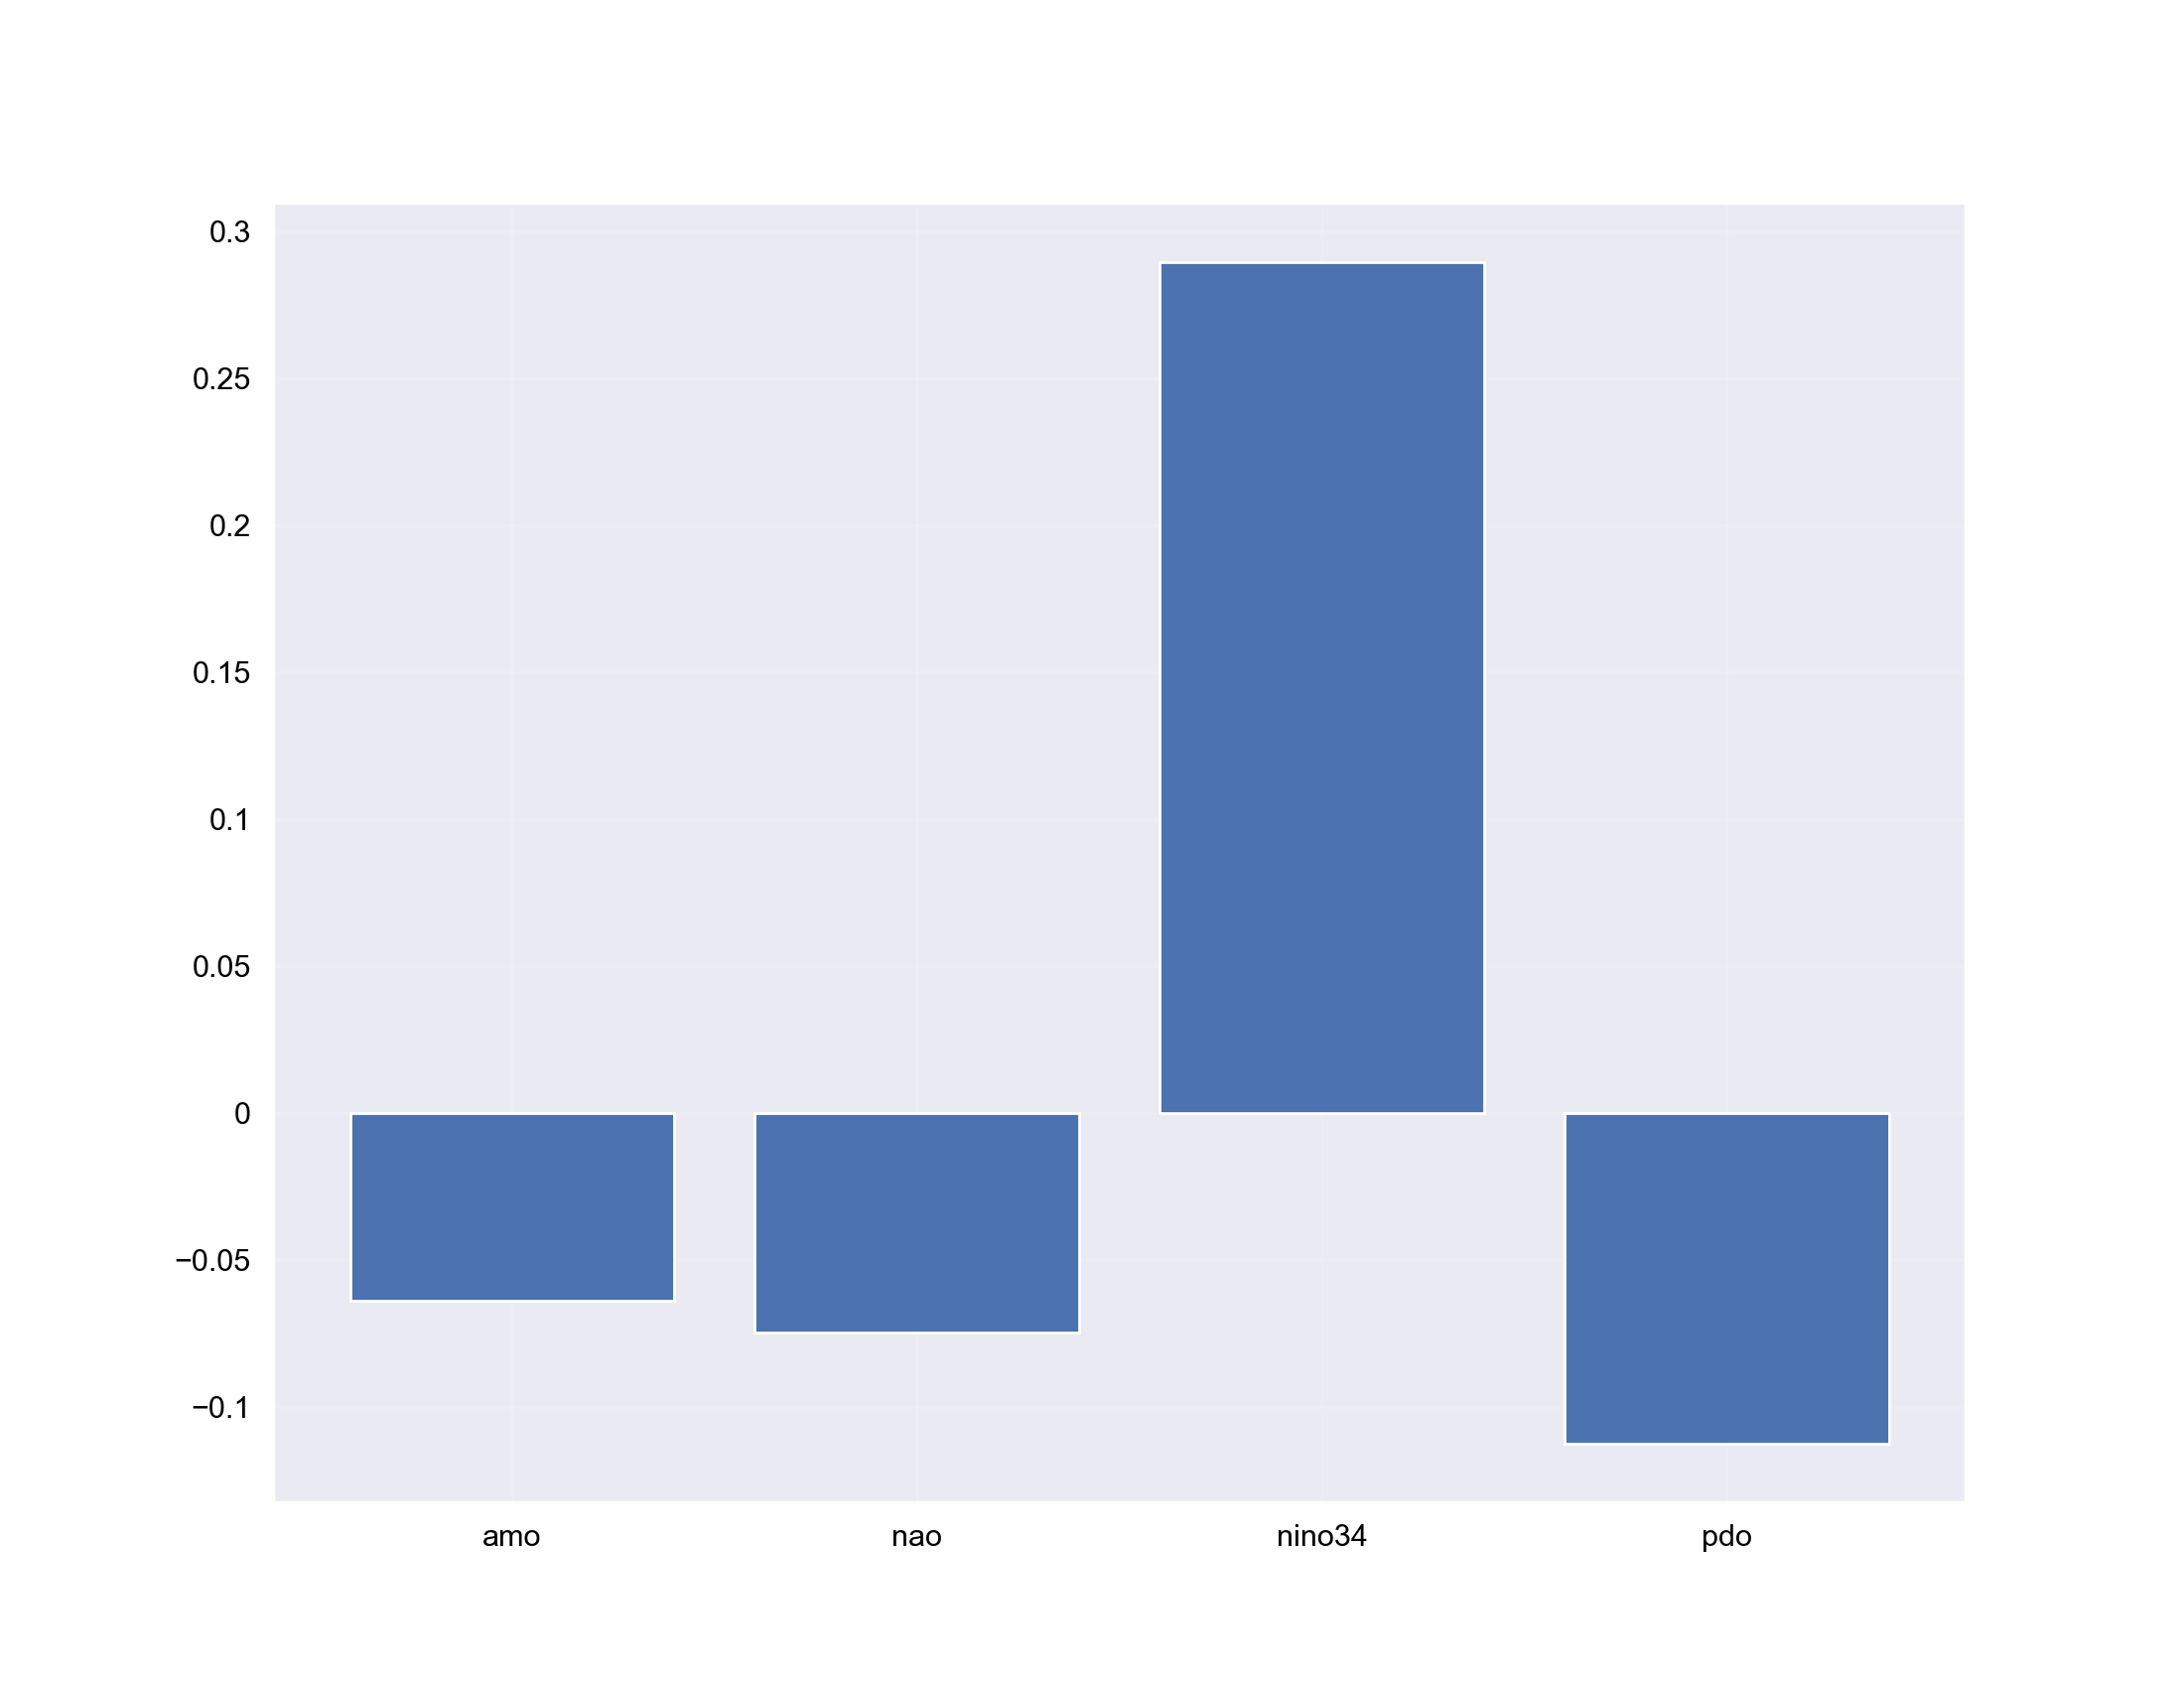

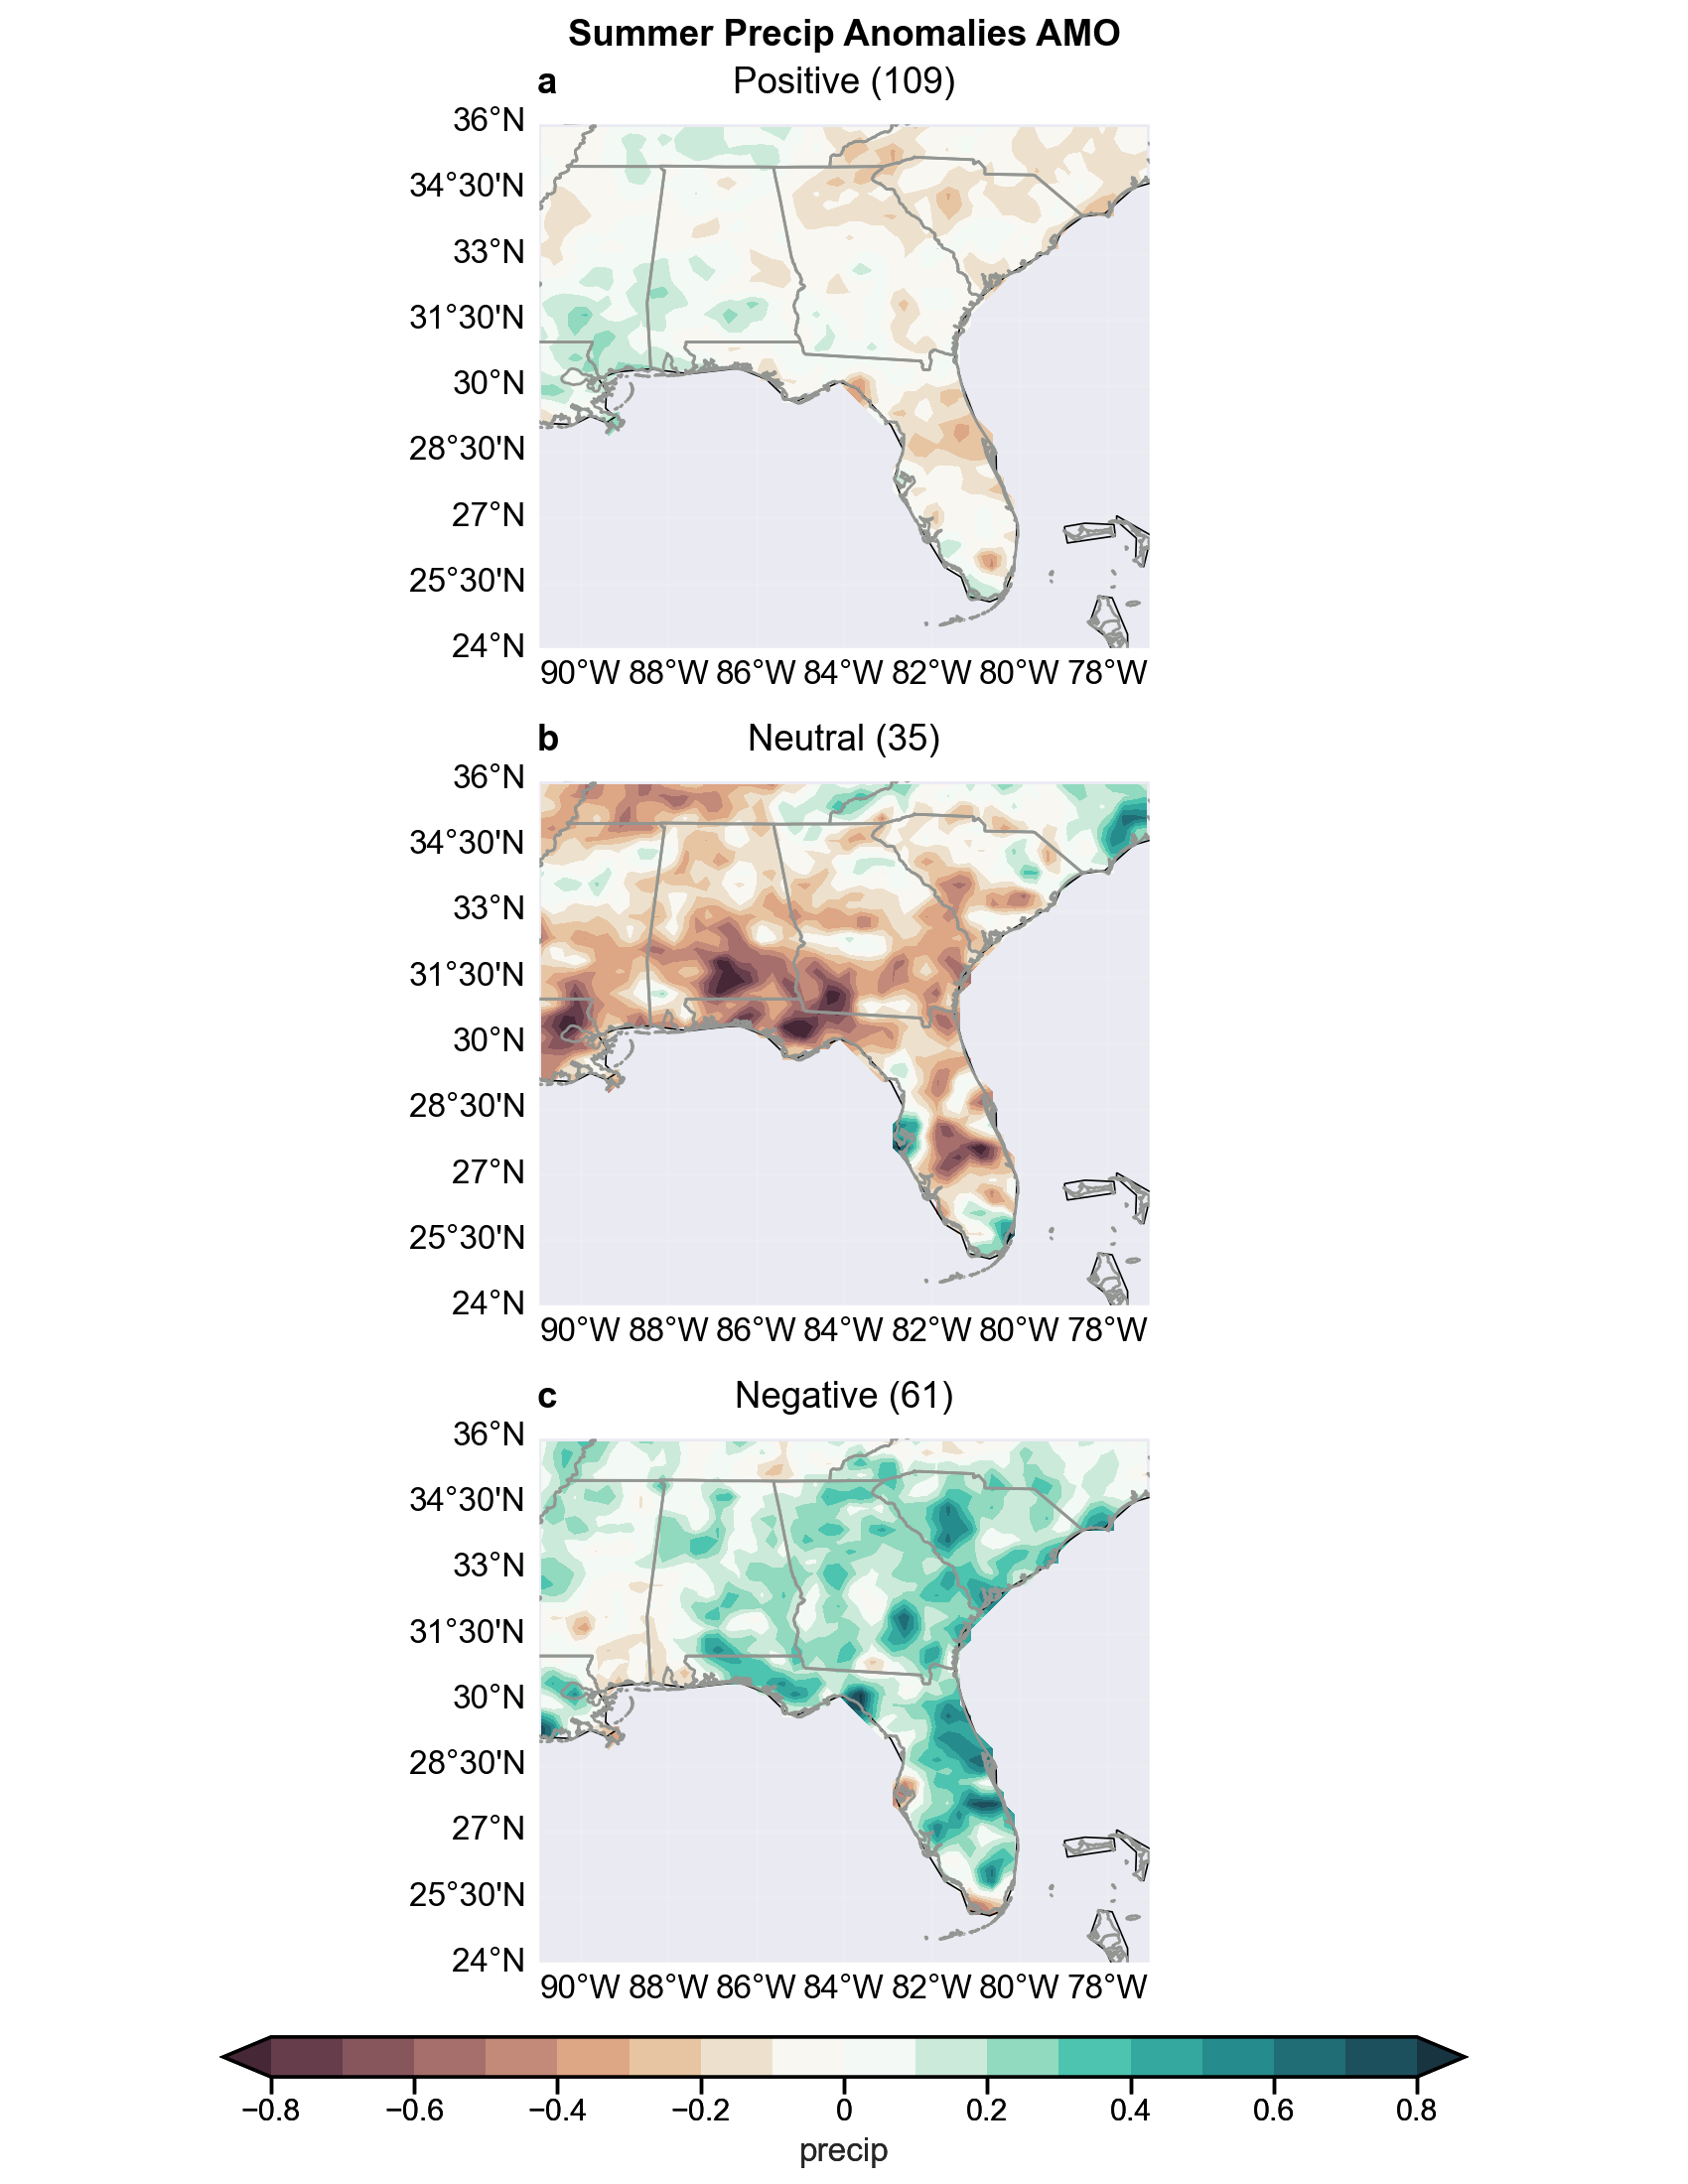

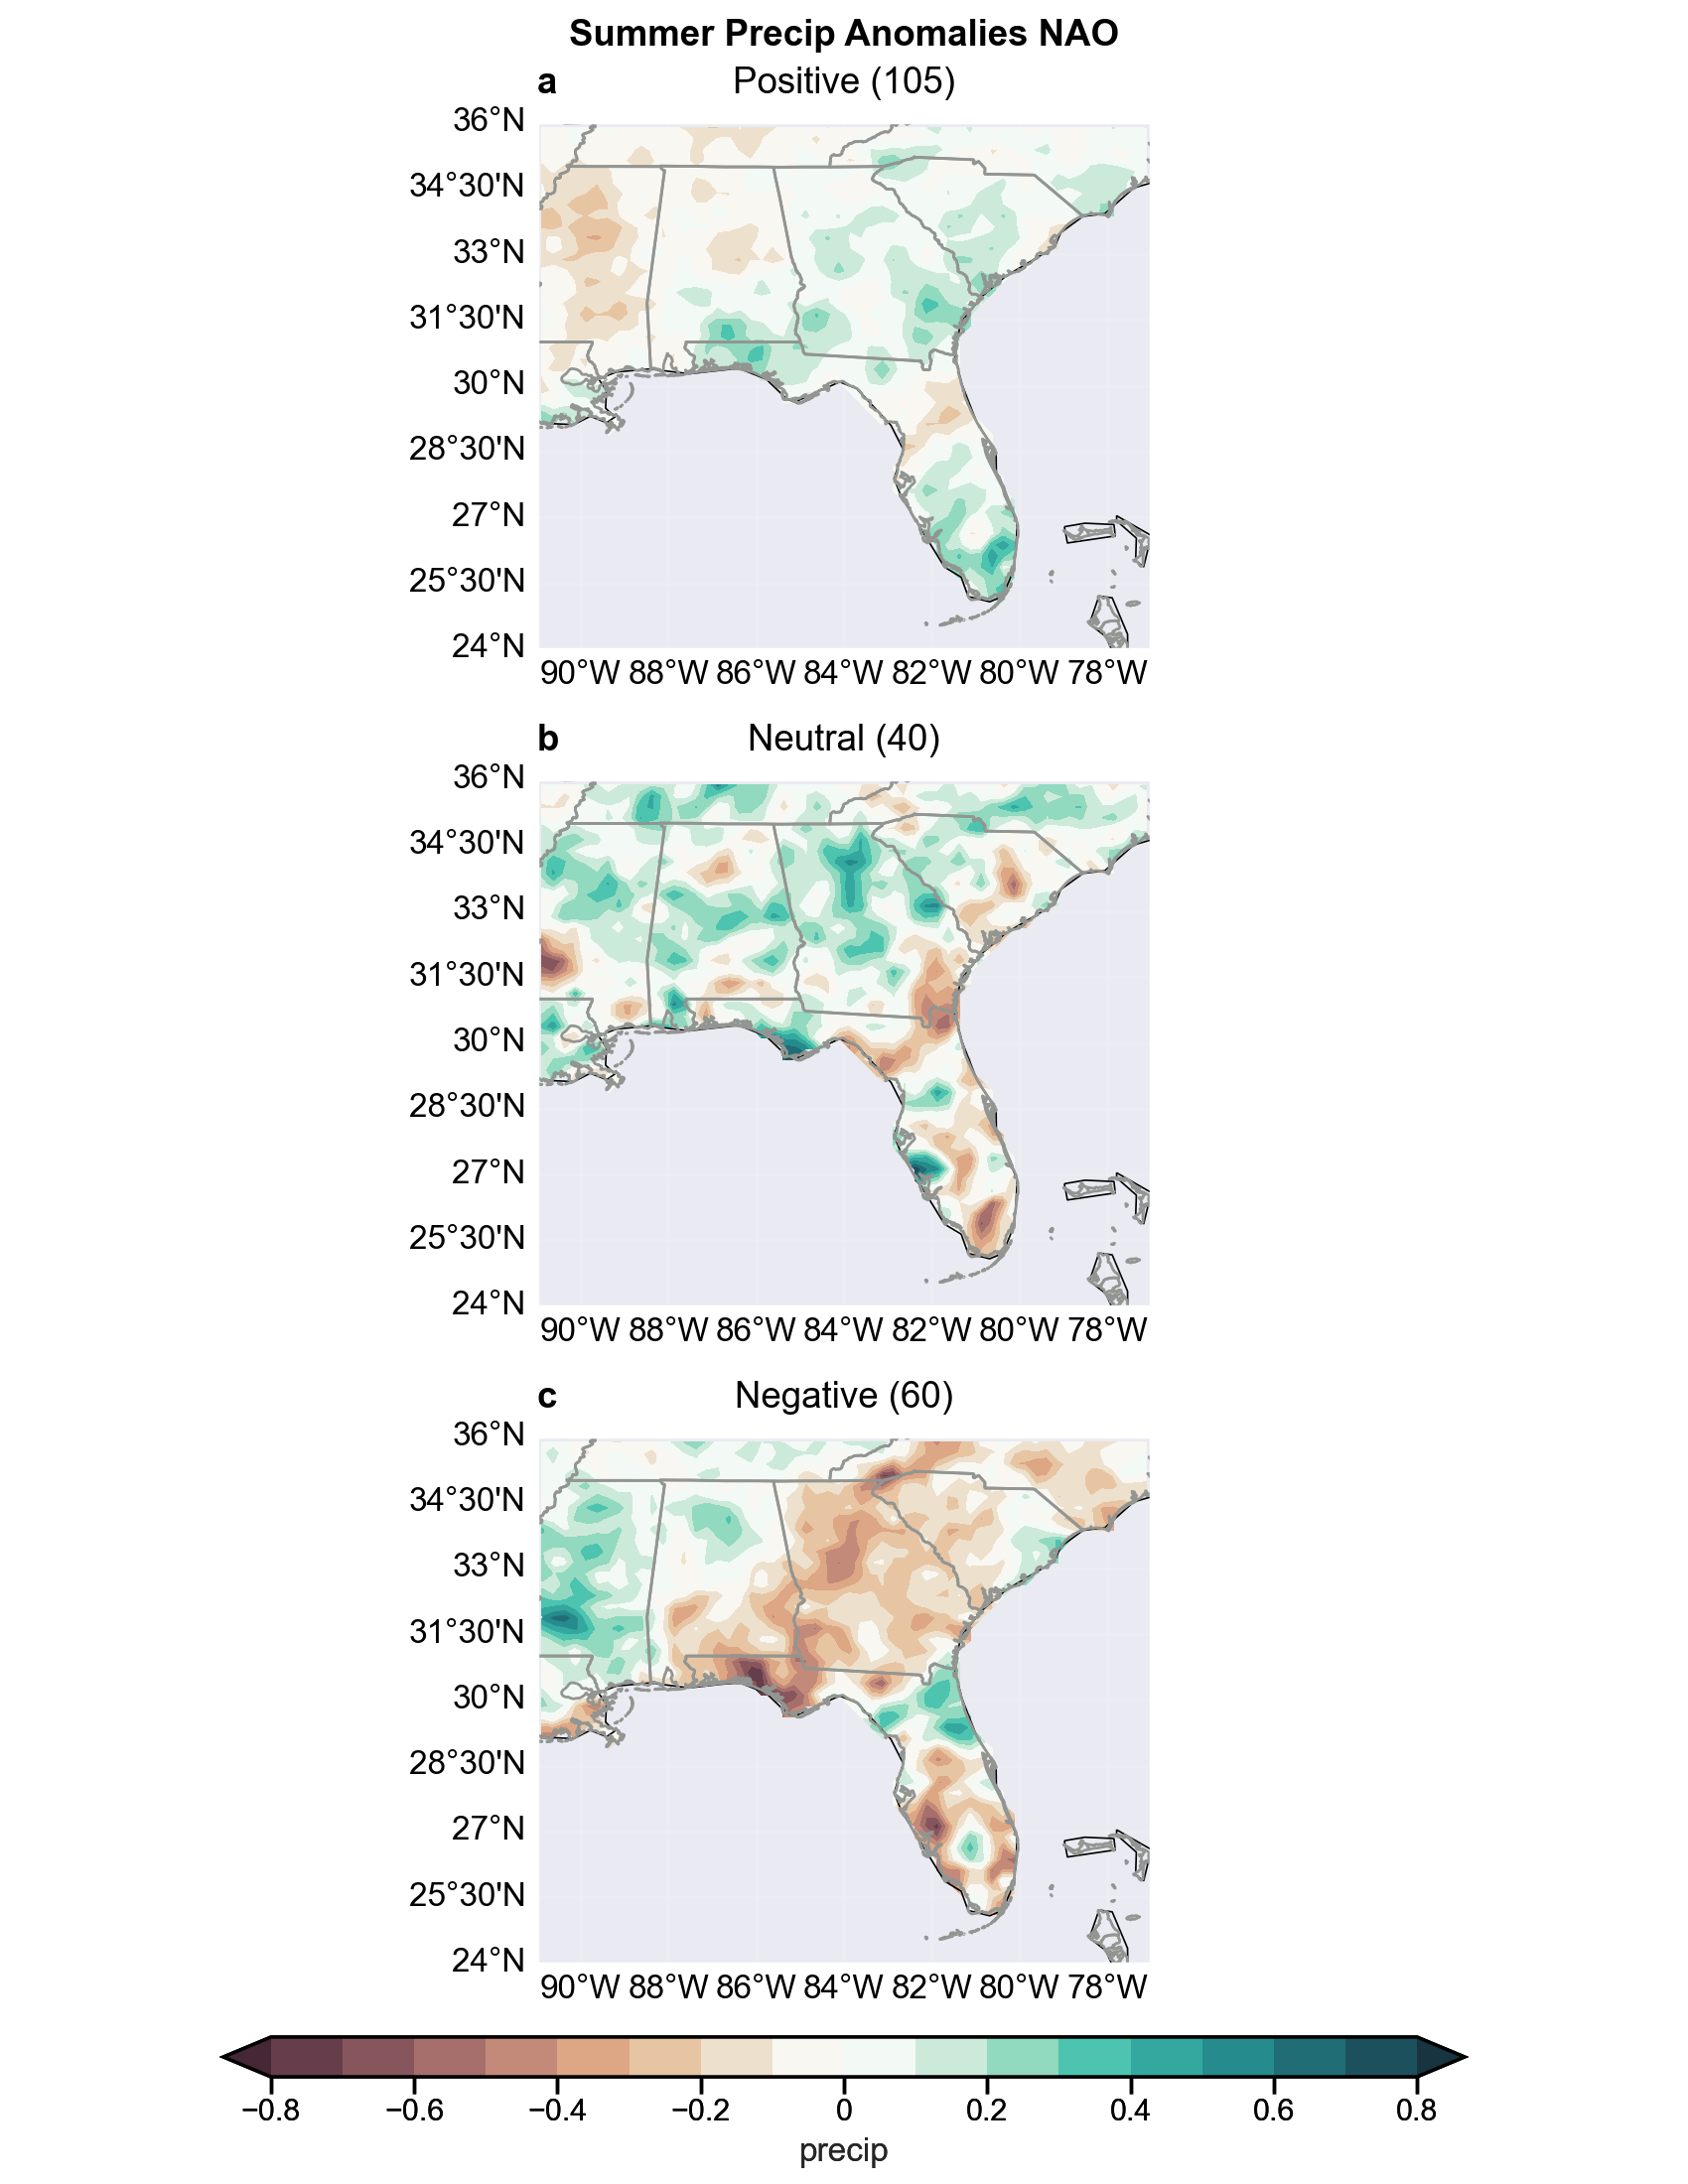

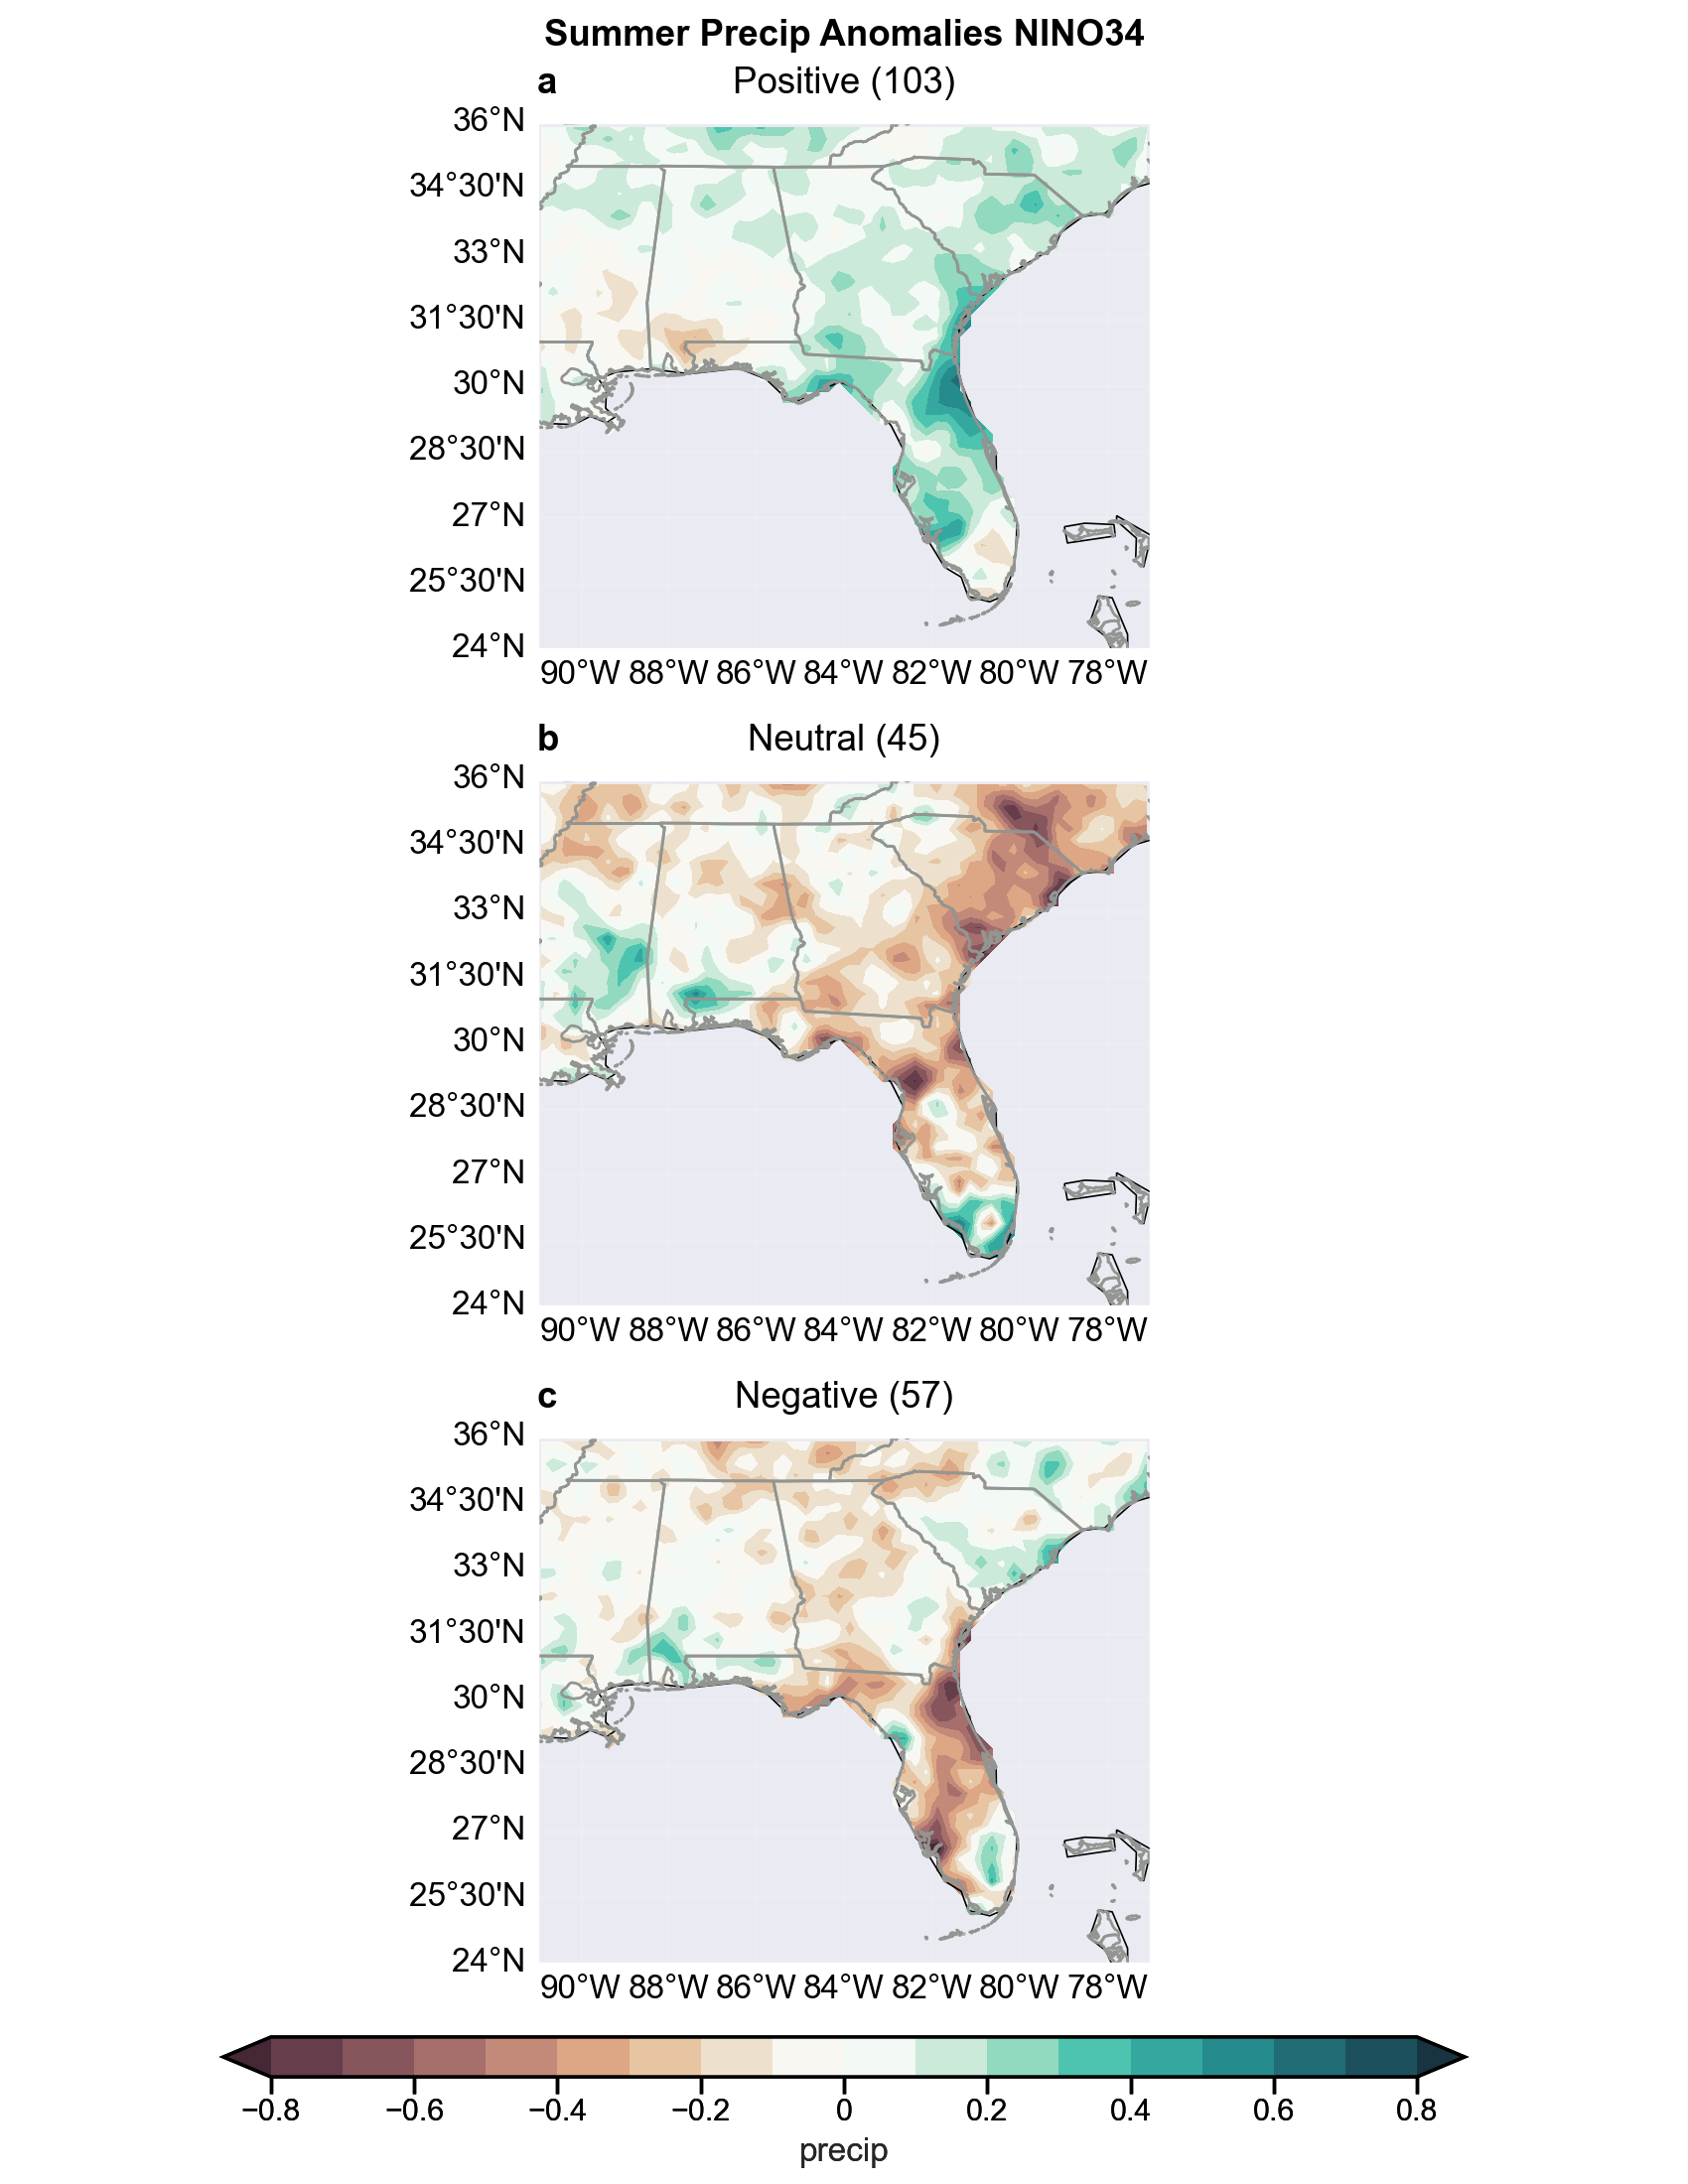

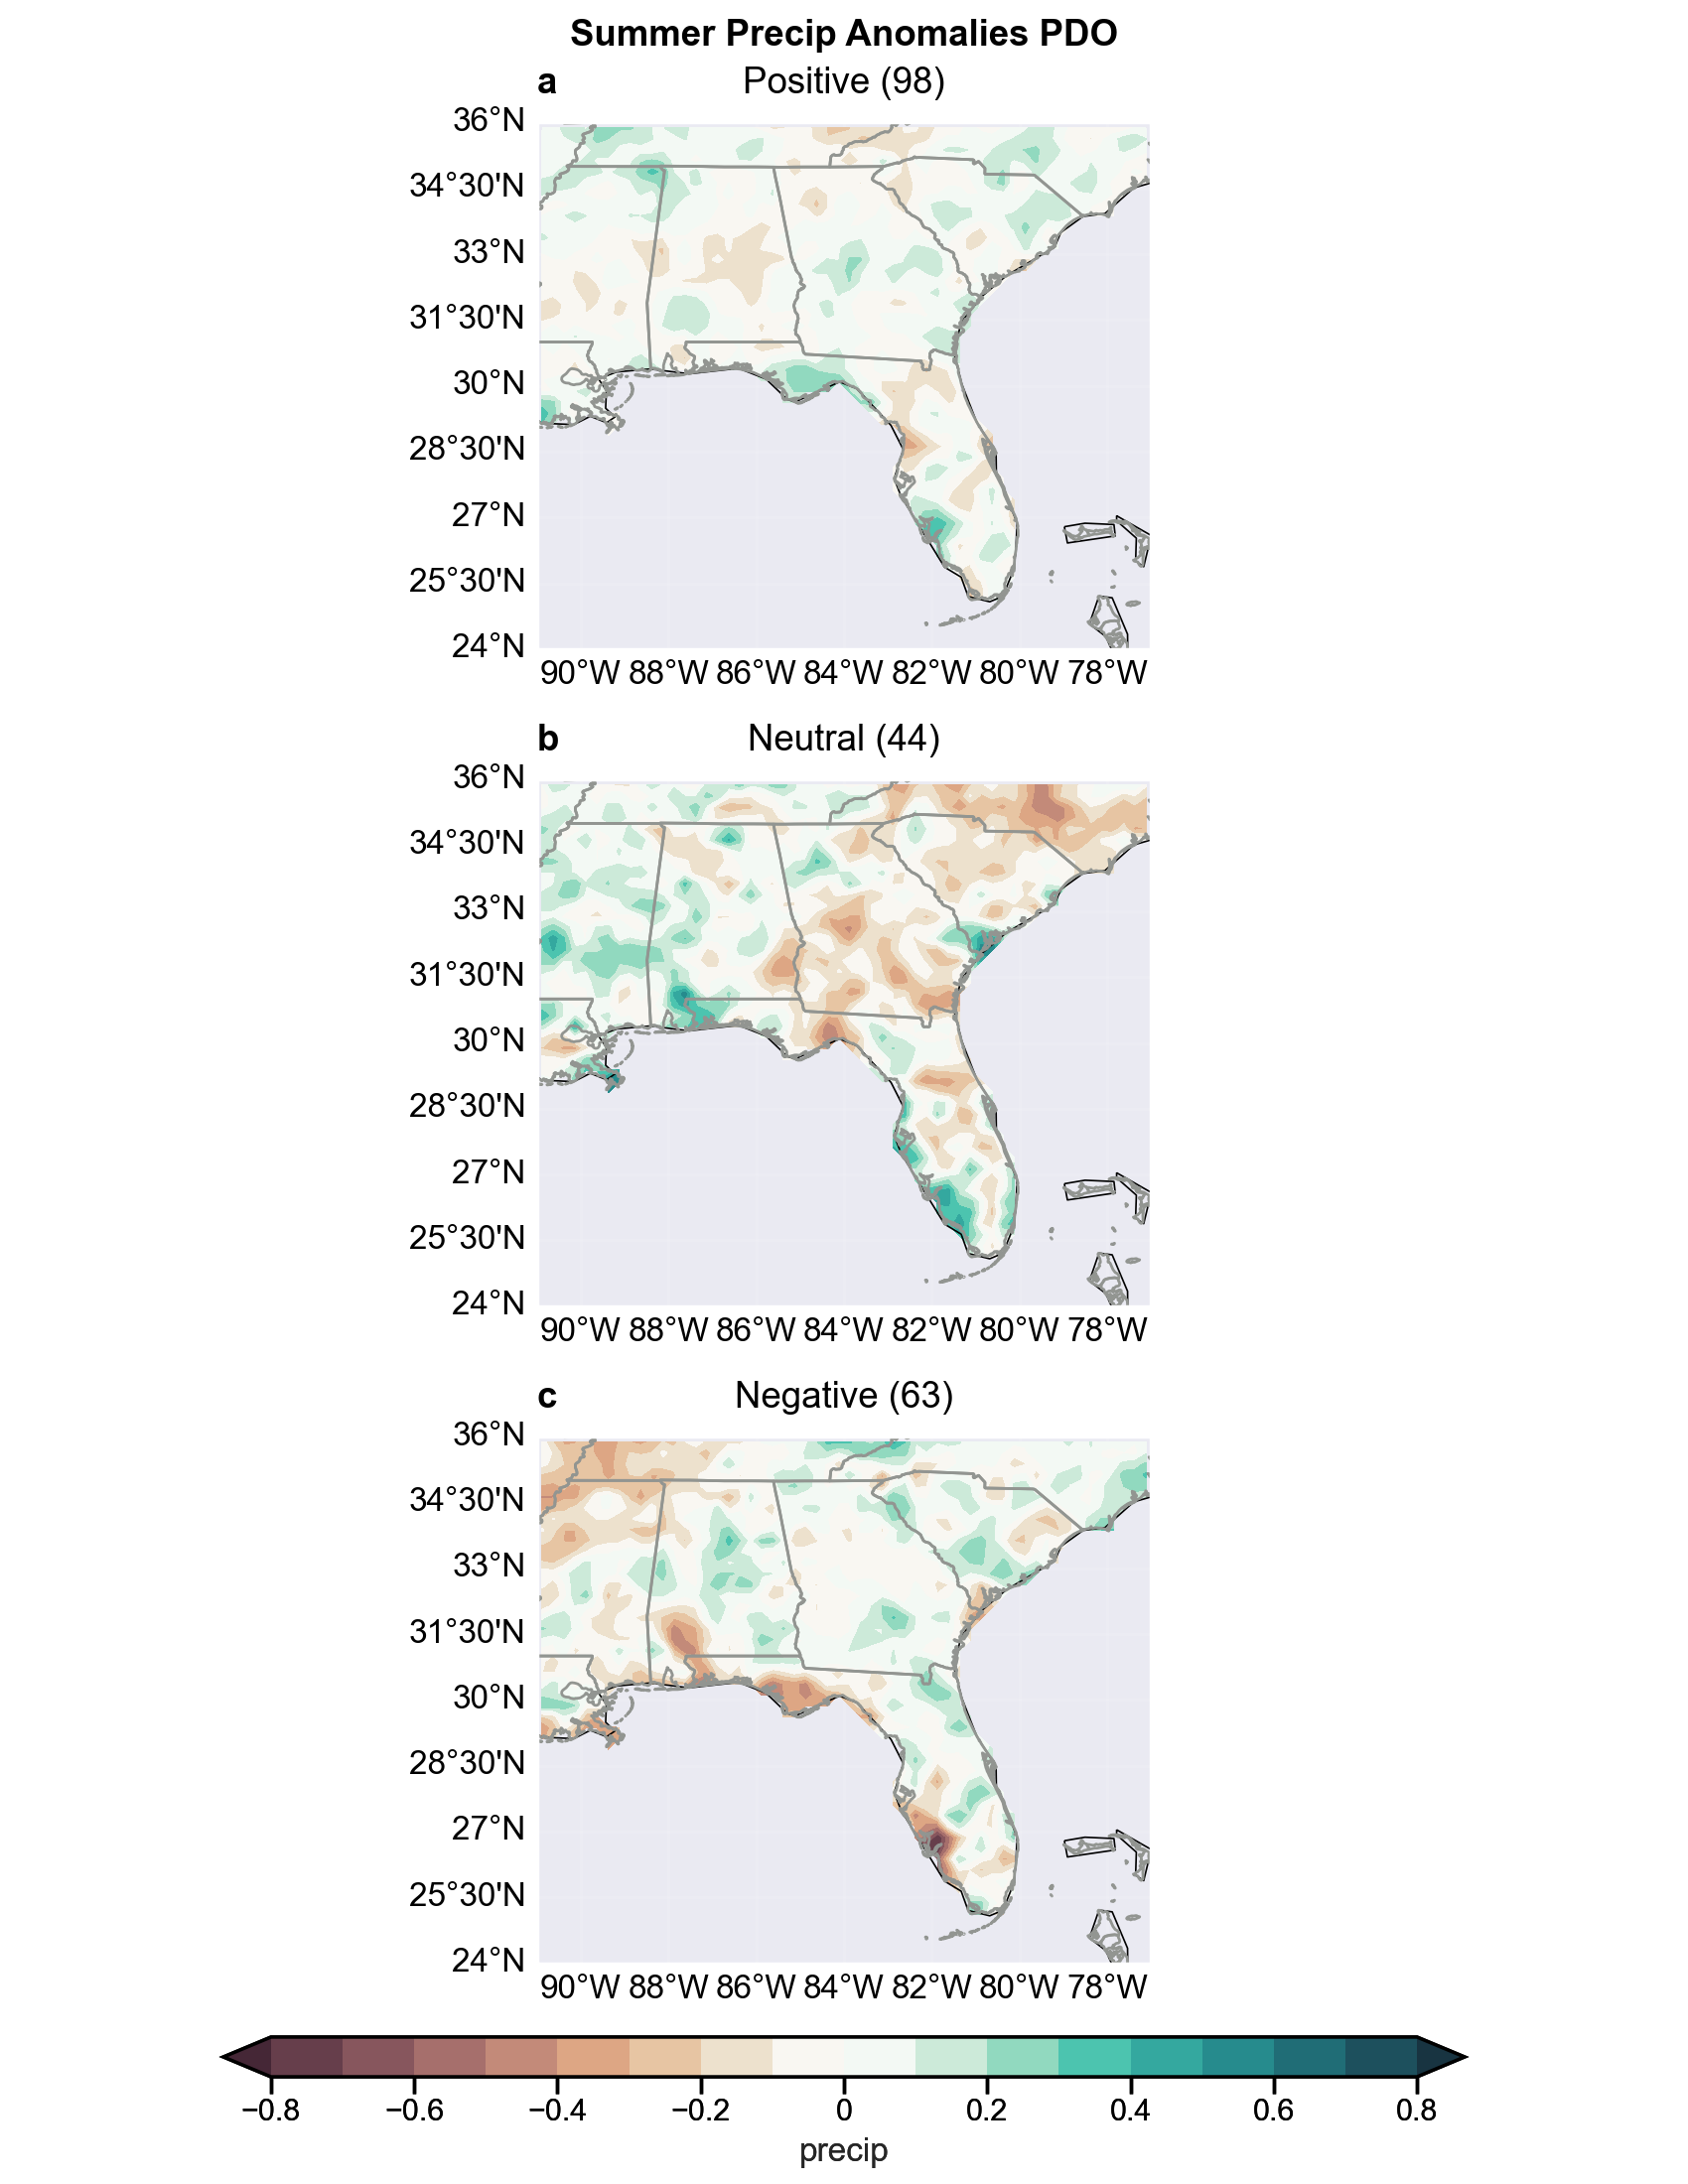

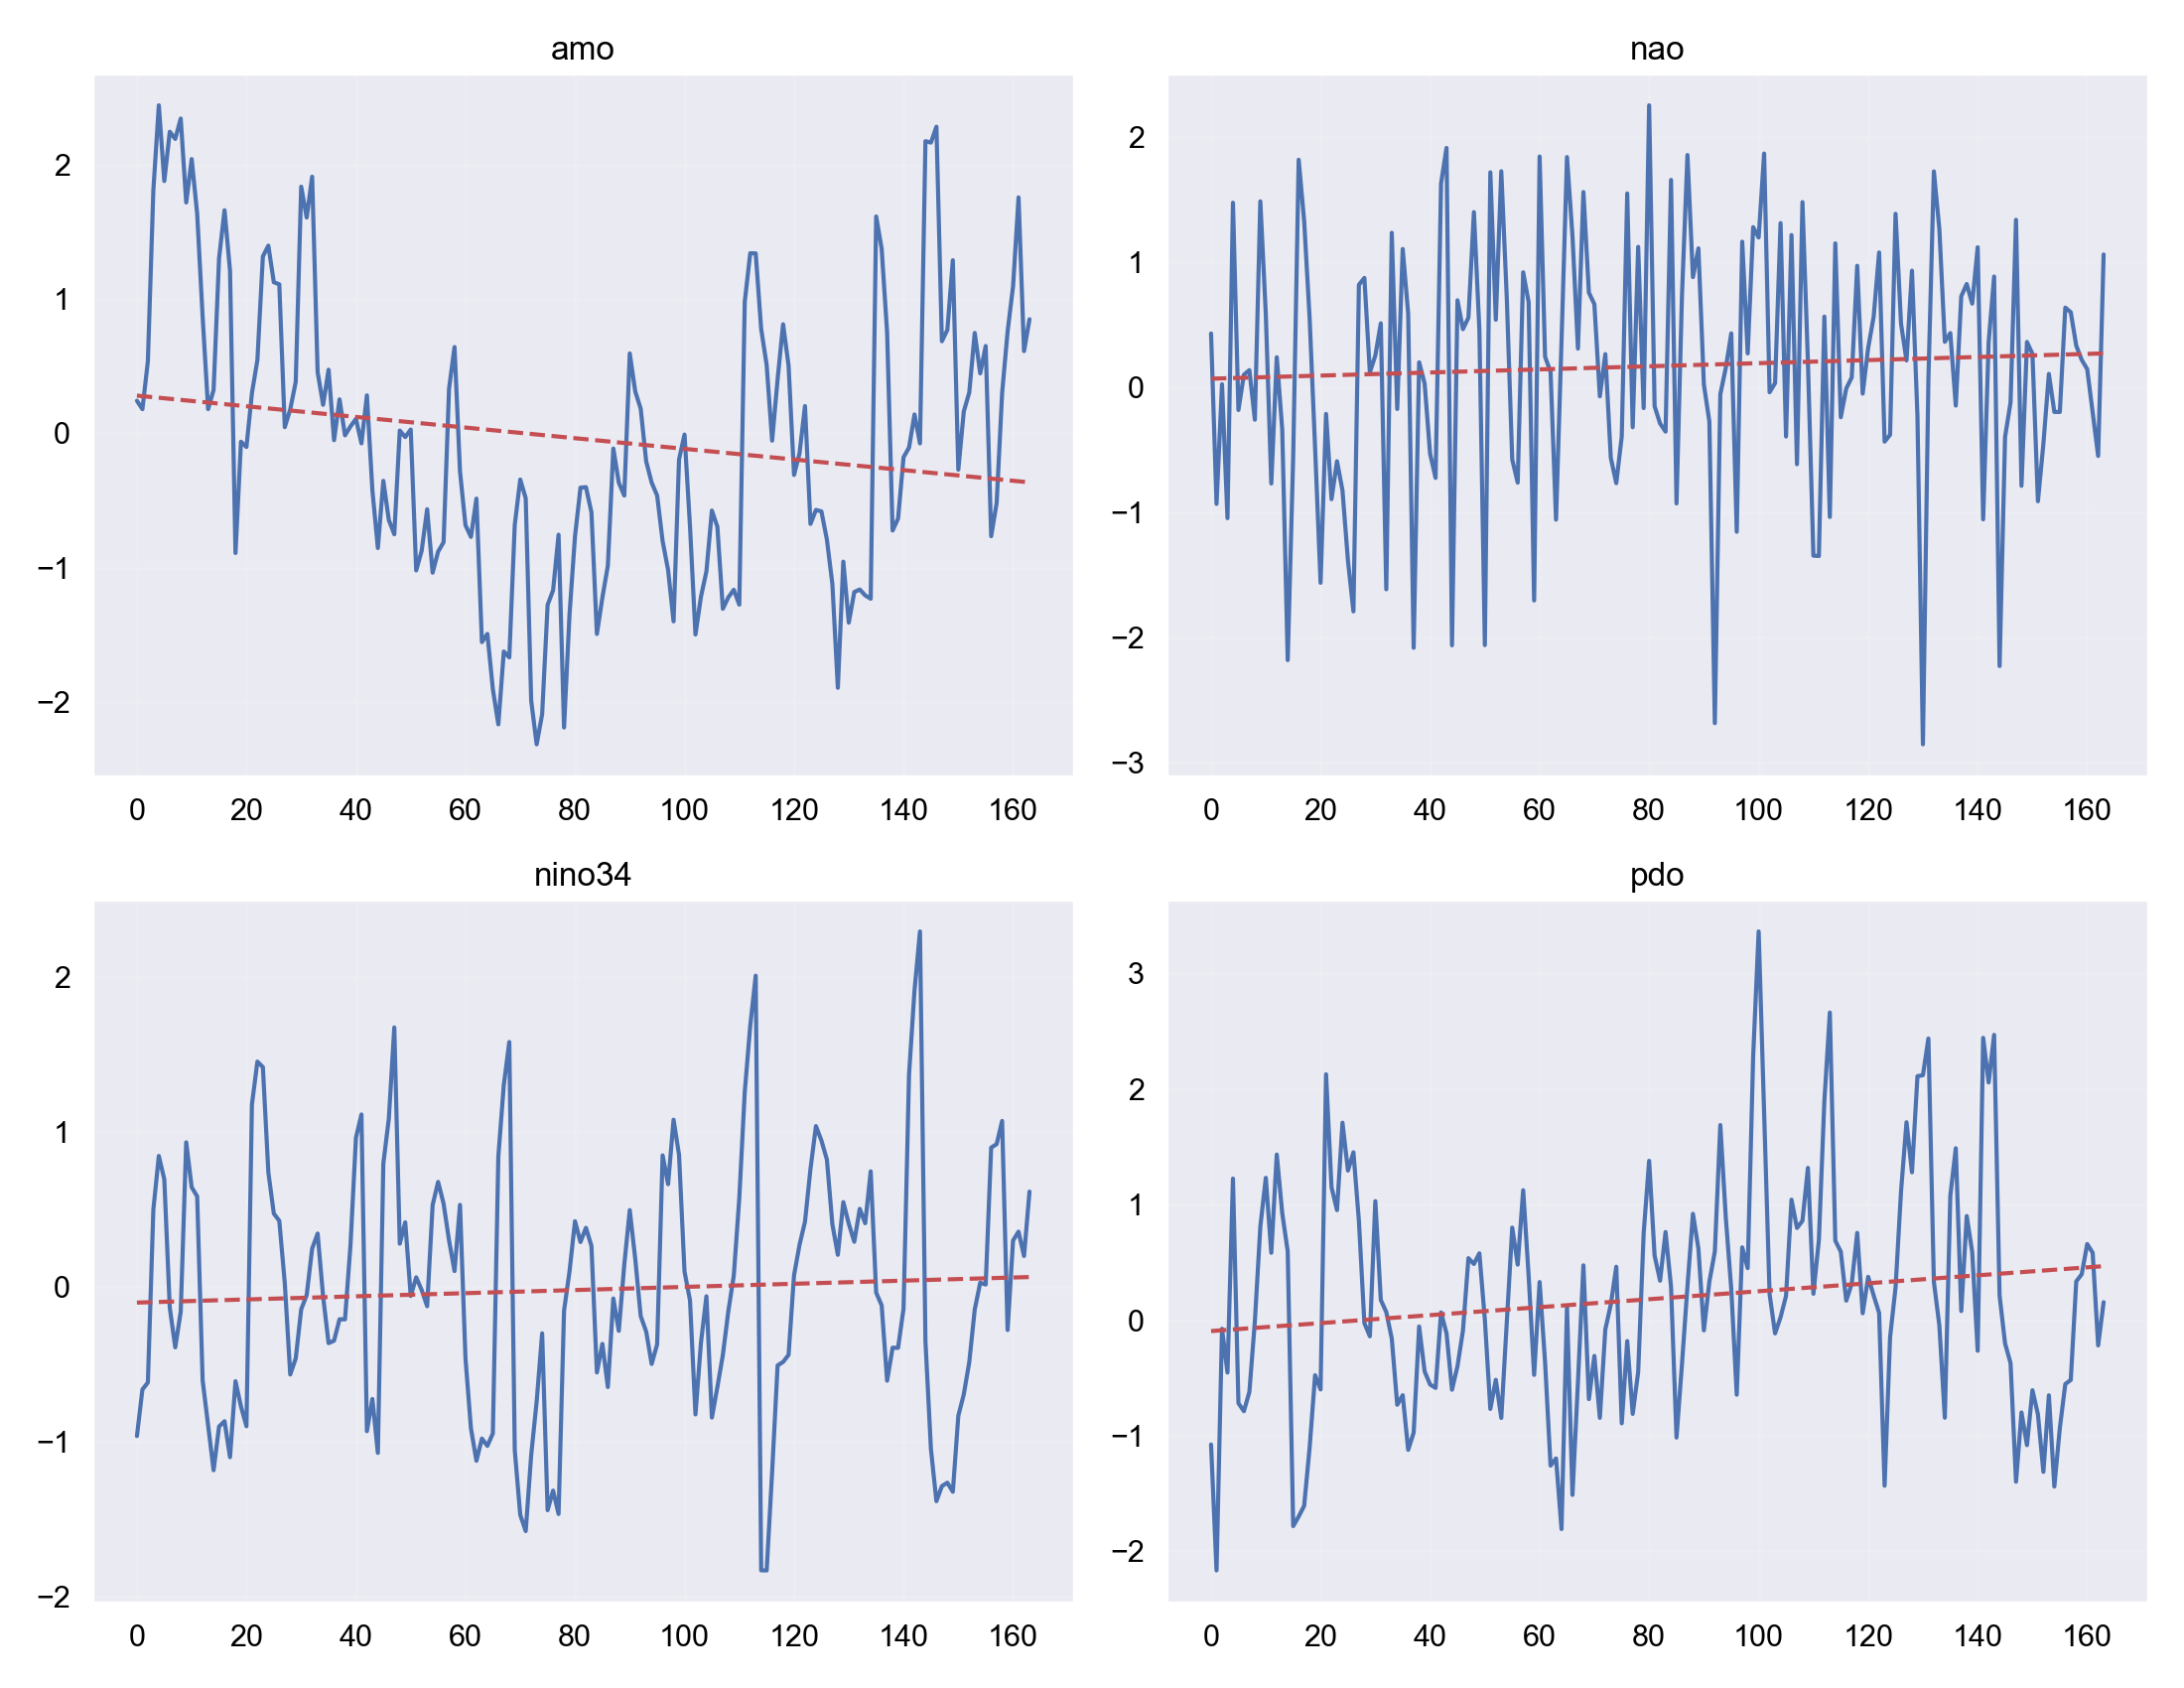

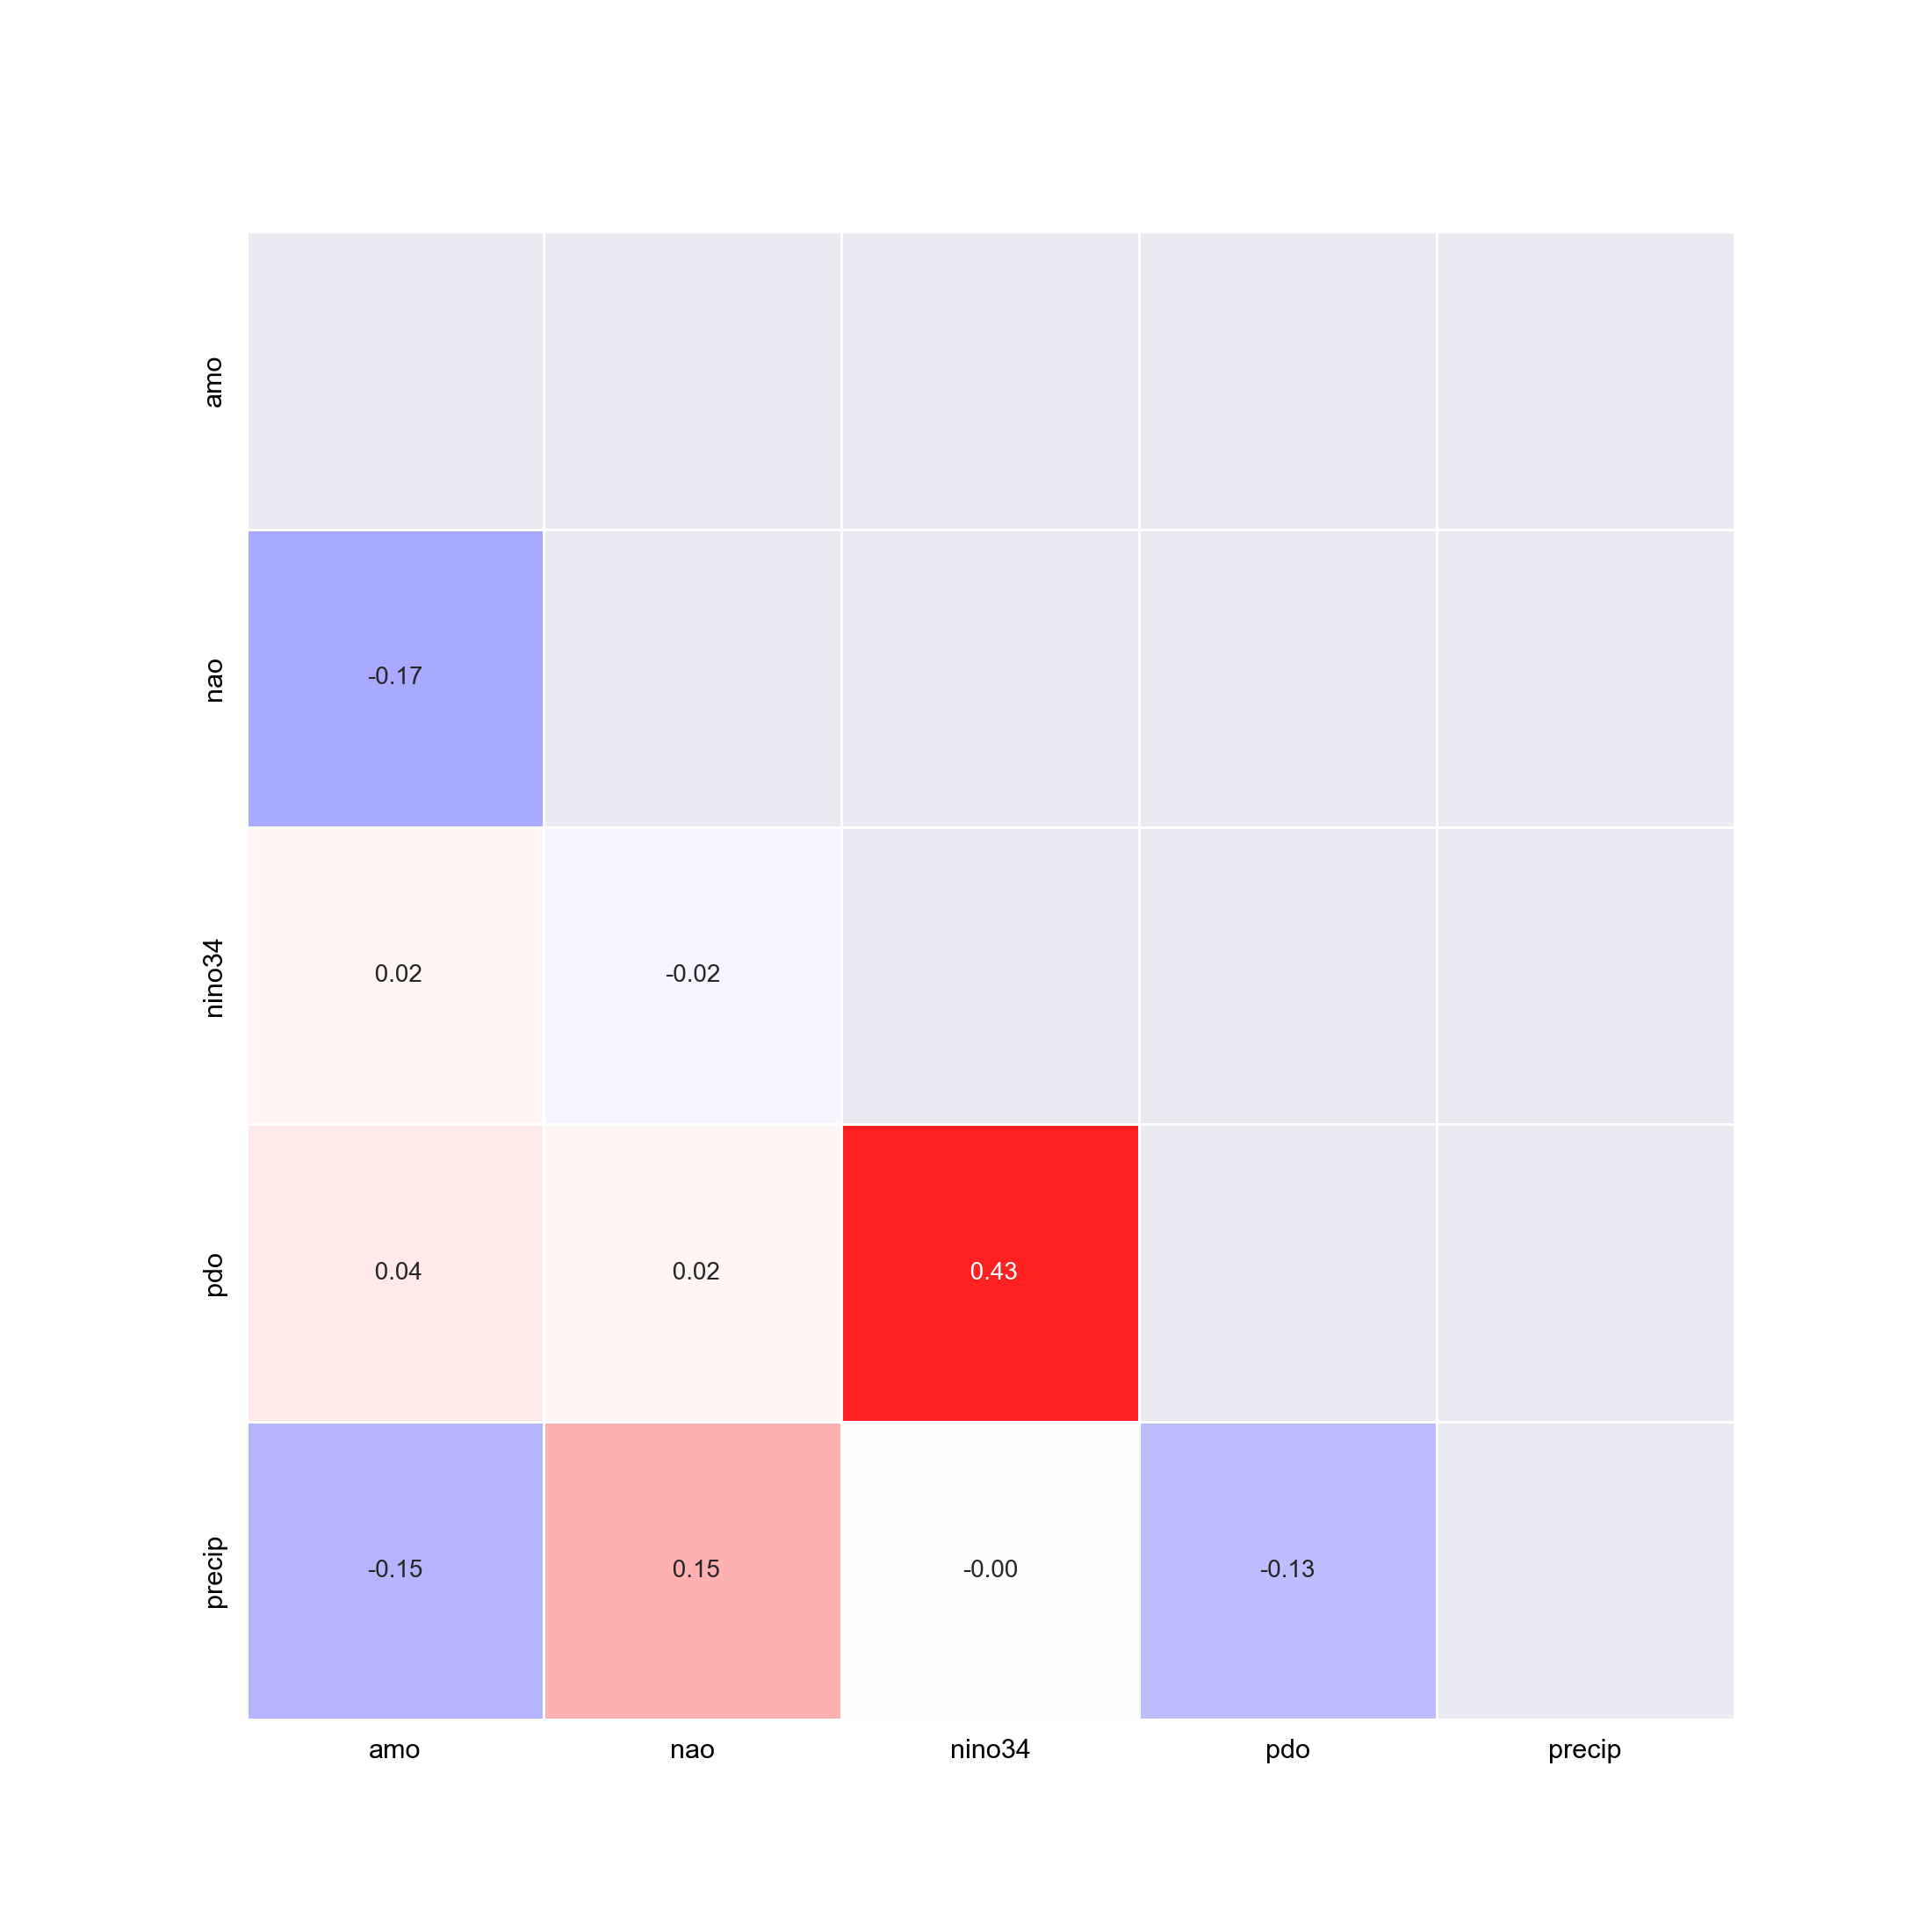

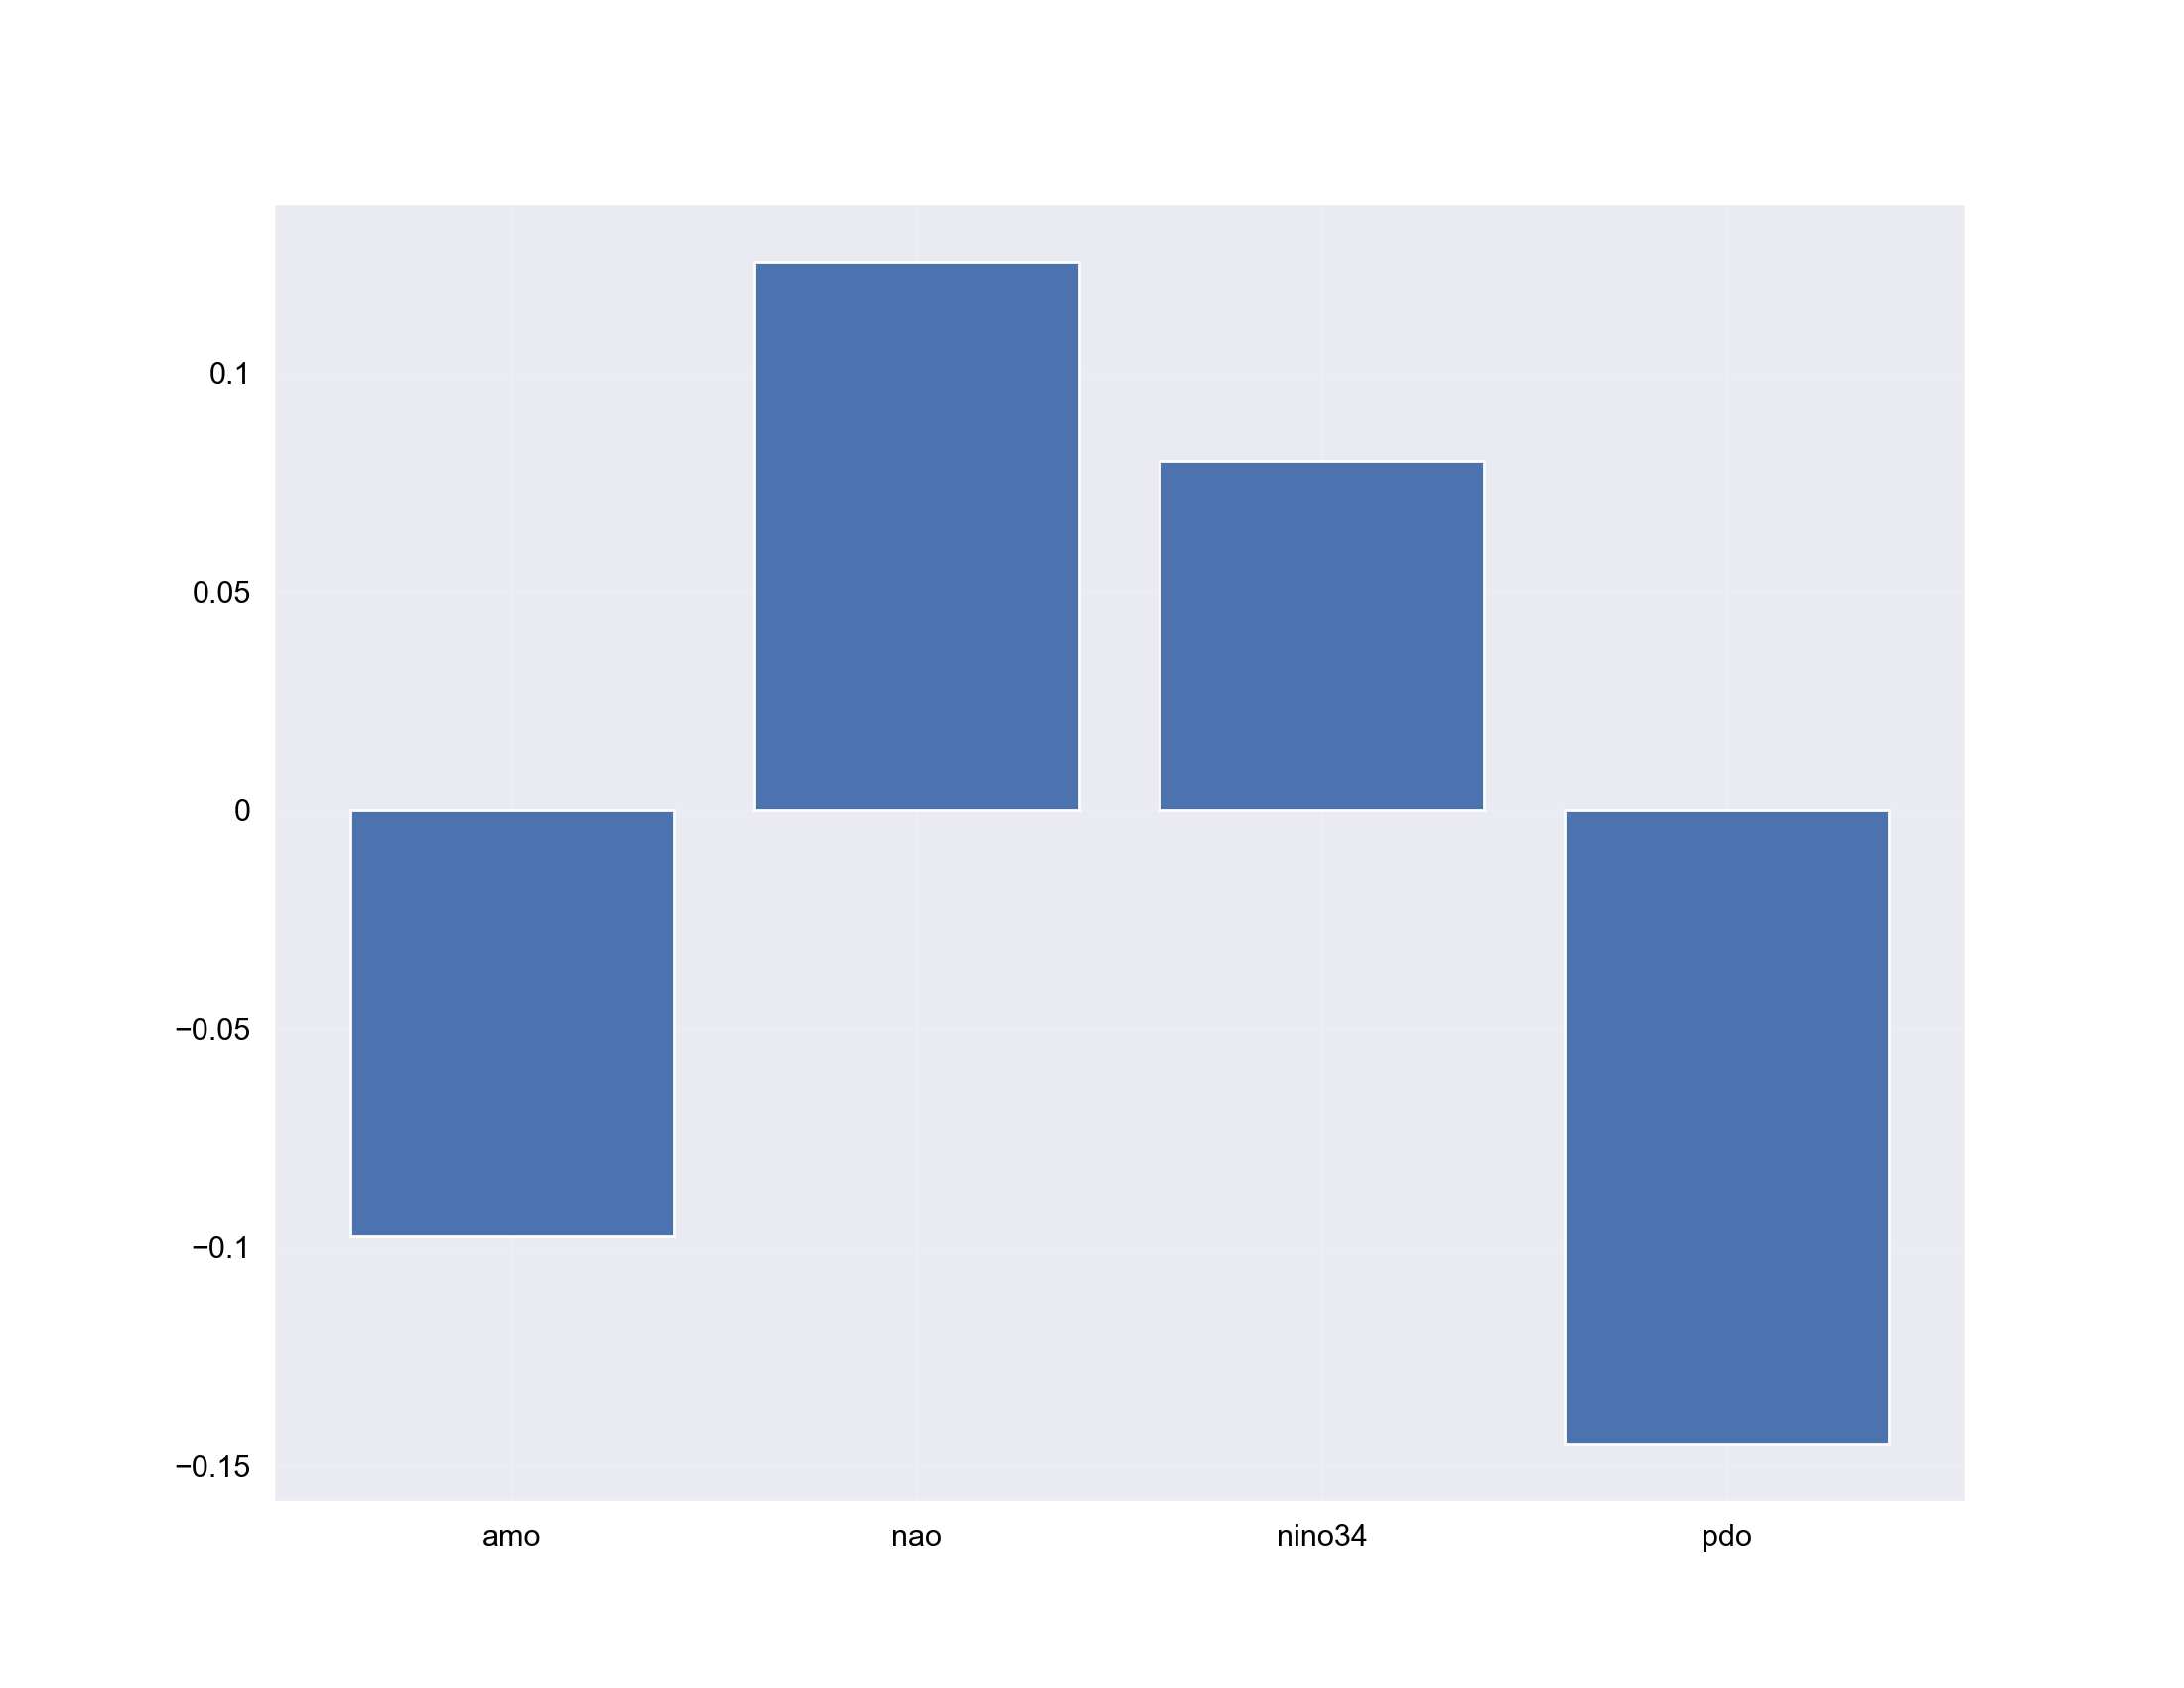

In [13]:
# Loop over seasons
for seas,slabel in zip([winter,summer],['Winter','Summer']):
    
    print(slabel)
    
    # Select season for indices, precip
    ds_i=ds_indices.sel(time=ds_indices['time.month'].isin(seas))
    ds_p=ds_anoms.sel(time=ds_anoms['time.month'].isin(seas))
    
    # Composites based on indices for this season
    for i,f in enumerate(indices):
        
        print(f.upper())
        
        ds_bins=makeBins(ds_i,f,3)
        ds=xr.merge([ds_p,ds_bins])
        ds_comp,totals=calcComposites(ds,f,labels)
        ds_totals=xr.concat(totals,dim=f+'_bins').to_dataset(name='bins_count')
 
        suptitle=slabel+' '+v.capitalize()+' Anomalies '+f.upper()
        compfile='../figs/comp_anomaly.'+slabel+'.'+v+'.'+f+'.png'
        plotComposites(ds_comp,f,totals,suptitle,labels,clevs,cmap,compfile)
        
    # ML Model for this season
    
    # Setup Features (X) and Target (Y)
    # Features: AMO, NAO, Nino34, PDO; Target: SEUS Precip Index
    
    X=np.stack((ds_i['amo'].values,ds_i['nao'].values,ds_i['nino34'],ds_i['pdo']),axis=-1)
    Y=ds_i['precip'].values

    print('Check Features and Target Dimensions')
    print('Features (X): ',X.shape)
    print('Target (Y): ',Y.shape)

    nsamples=X.shape[0]
    nfeatures=X.shape[1]

    print("Samples: ",nsamples)
    print("Features: ", nfeatures)
    
    # Create Train and Test Sets
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8,shuffle=False)

    ntrain=X_train.shape[0]
    ntest=X_test.shape[0]

    print('Training Size: ',ntrain)
    print('Testing Size: ',ntest)
    
    # Take a look at the Training Data
    
    plt.figure(figsize=(11,8.5))
    y=np.arange(ntrain)

    for i,f in enumerate(indices):

        plt.subplot(2,2,i+1)

        z = np.polyfit(y,X_train[:,i],1)
        p = np.poly1d(z)
    
        plt.plot(y,X_train[:,i])
        plt.plot(p(y),"r--")
        plt.title(f)

        print("Check Stats: ", "Index: ",f, "Mean: ", X_train[:,i].mean(axis=0),"Var: ", X_train[:,i].var(axis=0))
    plt.tight_layout()  
    
    # Make a heatmap
    heatmap(X_train,Y_train,list(ds_i.keys()))
    
    # Train the Models
    regr_lr,coeffs_lr,rsq_train_lr,Ypred_lr=lr(X_train,Y_train)
    print('R^2 Train Standard : ', rsq_train_lr)
    regr_lasso,coeffs_lasso,rsq_train_lasso,Ypred_lasso=lasso(X_train,Y_train)
    print('R^2 Train LASSO : ', rsq_train_lasso)
    regr_ridge,coeffs_ridge,rsq_train_ridge,Ypred_ridge=ridge(X_train,Y_train)
    print('R^2 Train Ridge : ', rsq_train_ridge)
    nn=tomsensomodel_regression(X_train,Y_train)
    rsq_train_nn,Y_pred_train_nn=get_r2(X_train,Y_train,nn)
    print('R^2 Train NN: ',rsq_train_nn)
    
    # Predict for Test
    rsq_test_lr,Y_pred_test_lr=get_r2(X_test,Y_test,regr_lr)
    print('R^2 Test Standard: ',rsq_test_lr)
    rsq_test_lasso,Y_pred_test_lasso=get_r2(X_test,Y_test,regr_lasso)
    print('R^2 Test Lasso: ',rsq_test_lasso)
    rsq_test_ridge,Y_pred_test_ridge=get_r2(X_test,Y_test,regr_ridge)
    print('R^2 Test Ridge: ',rsq_test_lr)
    rsq_test_nn,Y_pred_test_nn=get_r2(X_test,Y_test,nn)
    print('R^2 Test NN: ',rsq_test_nn)
    
    # Plot Coefficients for Standard Linear Regression
    plt.figure(figsize=(11,8.5))
    plt.bar(indices,coeffs_lr)